# Conditional Autoencoder for Asset Pricing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from pathlib import Path
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from sklearn.preprocessing import minmax_scale, quantile_transform
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
idx =pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [6]:
with pd.HDFStore('autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: autoencoder.h5
/close                      frame        (shape->[7559,3657]) 
/factor/beta                frame        (shape->[2363186,1]) 
/factor/betasq              frame        (shape->[2363186,1]) 
/factor/chmom               frame        (shape->[2700206,1]) 
/factor/dolvol              frame        (shape->[2806487,1]) 
/factor/idiovol             frame        (shape->[2615472,1]) 
/factor/ill                 frame        (shape->[2572109,1]) 
/factor/indmom              frame        (shape->[2849516,1]) 
/factor/maxret              frame        (shape->[2856033,1]) 
/factor/mom12m              frame        (shape->[2700206,1]) 
/factor/mom1m               series       (shape->[2871156])   
/factor/mom36m              frame        (shape->[2361477,1]) 
/factor/mvel                frame        (shape->[2874317,1]) 
/factor/retvol              frame        (shape->[2871156,1]) 
/factor/turn                frame        (shape->[2774

### Weekly returns

In [7]:
data = pd.read_hdf('autoencoder.h5', 'returns').stack(dropna=False).to_frame('returns').loc[idx['1993':, :], :]

In [8]:
with pd.HDFStore('autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [9]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [10]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [11]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5152713 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2019-12-27 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2770456 non-null  float64
 1   beta         2360139 non-null  float64
 2   betasq       2360139 non-null  float64
 3   chmom        2626339 non-null  float64
 4   dolvol       2704165 non-null  float64
 5   idiovol      2325661 non-null  float64
 6   ill          2489829 non-null  float64
 7   indmom       2770303 non-null  float64
 8   maxret       2748720 non-null  float64
 9   mom12m       2626339 non-null  float64
 10  mom1m        2760621 non-null  float64
 11  mom36m       2358433 non-null  float64
 12  mvel         2761081 non-null  float64
 13  retvol       2760621 non-null  float64
 14  turn         2677256 non-null  float64
 15  turn_std     2705590 non-null  fl

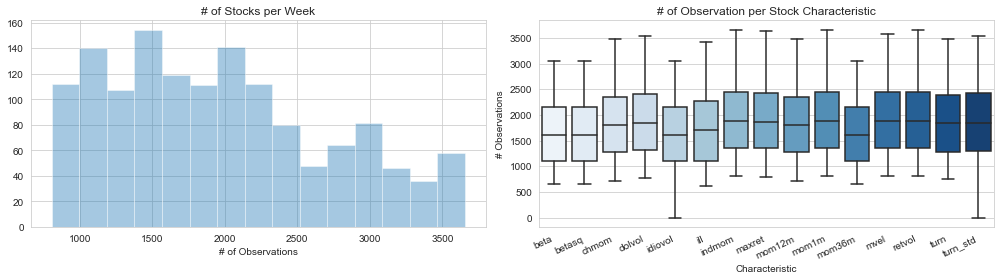

In [12]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(), 
                                 value_name='# Observations', 
                                 var_name=['Characteristic'])
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
sns.distplot(nobs_by_date, kde=False, ax=axes[0])
axes[0].set_title('# of Stocks per Week')
axes[0].set_xlabel('# of Observations')
sns.boxplot(x='Characteristic', y='# Observations', data=nobs_by_characteristic, ax=axes[1], palette='Blues')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha='right')
axes[1].set_title('# of Observation per Stock Characteristic')
fig.tight_layout();

### Rank-normalize characteristics

In [13]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [14]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5152713 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2019-12-27 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2770456 non-null  float64
 1   beta         2360139 non-null  float64
 2   betasq       2360139 non-null  float64
 3   chmom        2626339 non-null  float64
 4   dolvol       2704165 non-null  float64
 5   idiovol      2325661 non-null  float64
 6   ill          2489829 non-null  float64
 7   indmom       2770303 non-null  float64
 8   maxret       2748720 non-null  float64
 9   mom12m       2626339 non-null  float64
 10  mom1m        2760621 non-null  float64
 11  mom36m       2358433 non-null  float64
 12  mvel         2761081 non-null  float64
 13  retvol       2760621 non-null  float64
 14  turn         2677256 non-null  float64
 15  turn_std     2705590 non-null  fl

In [15]:
data.index.names

FrozenList(['date', 'ticker'])

In [16]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,2.770456e+06,2.360139e+06,2.360139e+06,2.626339e+06,2.704165e+06,2.325661e+06,2.489829e+06,2.770303e+06,2.748720e+06,2.626339e+06,2.760621e+06,2.358433e+06,2.761081e+06,2.760621e+06,2.677256e+06,2.705590e+06,2.769651e+06
mean,3.056325e-03,-6.346325e-09,-5.837470e-07,-3.568177e-09,-1.705488e-06,-2.220134e-07,-5.689239e-07,-6.601156e-02,3.892305e-09,-2.118056e-07,-3.516596e-08,-2.538978e-07,7.696316e-08,-2.838747e-05,-7.312079e-07,-1.196178e-06,3.053796e-03
std,5.971123e-02,5.776945e-01,5.776952e-01,5.776593e-01,5.776536e-01,5.776868e-01,5.776766e-01,5.943010e-01,5.776439e-01,5.776594e-01,5.776404e-01,5.776946e-01,5.776445e-01,5.776925e-01,5.776546e-01,5.776515e-01,5.971491e-02
min,-9.990779e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.990779e-01
25%,-2.083260e-02,-5.003208e-01,-5.003129e-01,-5.002485e-01,-5.002425e-01,-5.003190e-01,-5.002694e-01,-6.050328e-01,-5.002516e-01,-5.002384e-01,-5.001822e-01,-5.002966e-01,-5.002188e-01,-5.002597e-01,-5.001962e-01,-5.002272e-01,-2.083303e-02
50%,1.052650e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.303063e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.052504e-03
75%,2.457069e-02,5.003180e-01,5.003072e-01,5.002701e-01,5.002333e-01,5.003078e-01,5.002665e-01,4.275164e-01,5.002268e-01,5.002394e-01,5.002492e-01,5.002883e-01,5.002044e-01,5.002251e-01,5.002270e-01,5.002306e-01,2.456899e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [21]:
data = data.loc[idx[:'2019', :], :]

In [22]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [23]:
data = data.fillna(-2)

In [24]:
data.to_hdf('autoencoder.h5', 'model_data')

## Architecture

In [6]:
data = pd.read_hdf('autoencoder.h5', 'model_data')

### Key parameters

In [7]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [8]:
n_tickers

3657

In [9]:
n_characteristics

15

### Input Layer

In [10]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [11]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [12]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [13]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [14]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [15]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_beta (InputLayer)         [(None, 3657, 15)]   0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 3657, 8)      128         input_beta[0][0]                 
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 3657, 8)      32          hidden_layer[0][0]               
__________________________________________________________________________________________________
input_factor (InputLayer)       [(None, 3657)]       0                                            
______________________________________________________________________________________________

## Train Model

### Callbacks

In [17]:
tb_path = Path('models', 'cond_auto')
if not tb_path.exists():
    tb_path.mkdir()

In [18]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True)

### Cross-validation parameters

In [19]:
YEAR = 52

In [20]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [21]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [22]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [23]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [24]:
batch_size = 32

In [25]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [26]:
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data, train_idx, val_idx)
        for epoch in range(250):         
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch, 
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val, X2_val]).reshape(-1), 
                                   'y_true': y_val.stack().values},
                                 index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])
            print(f'{n_factors} {units:02} | {fold:02}:{epoch:03} | {r0:6.2%} | {r1.mean():6.2%} | {r1.median():6.2%}')
            scores.append([units, n_factors, fold, epoch, r0, r1.mean(), r1.std(), r1.median()])
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf('scores.h5', f'{units}/{n_factors}')

2 08 | 00:000 | -2.48% | -2.48% | -2.83%
2 08 | 00:001 | -2.88% | -2.60% | -2.38%
2 08 | 00:002 | -2.72% | -2.44% | -1.92%
2 08 | 00:003 | -2.33% | -2.22% | -1.91%
2 08 | 00:004 | -2.09% | -1.93% | -1.87%
2 08 | 00:005 | -2.00% | -1.81% | -2.37%
2 08 | 00:006 | -1.70% | -1.42% | -2.26%
2 08 | 00:007 | -1.78% | -1.61% | -2.43%
2 08 | 00:008 | -1.84% | -1.52% | -2.31%
2 08 | 00:009 | -1.39% | -1.15% | -0.63%
2 08 | 00:010 | -1.64% | -1.37% | -1.12%
2 08 | 00:011 | -1.35% | -1.27% | -0.75%
2 08 | 00:012 | -1.62% | -1.32% | -0.88%
2 08 | 00:013 | -1.48% | -1.24% | -0.82%
2 08 | 00:014 | -1.44% | -1.21% | -0.47%
2 08 | 00:015 | -1.41% | -1.23% | -0.55%
2 08 | 00:016 | -1.25% | -1.10% | -1.20%
2 08 | 00:017 | -1.55% | -1.39% | -1.26%
2 08 | 00:018 | -1.38% | -1.28% | -1.48%
2 08 | 00:019 | -1.55% | -1.44% | -1.50%
2 08 | 00:020 | -1.40% | -1.33% | -1.50%
2 08 | 00:021 | -1.30% | -1.21% | -1.37%
2 08 | 00:022 | -1.61% | -1.47% | -1.71%
2 08 | 00:023 | -1.49% | -1.45% | -1.90%
2 08 | 00:024 | 

2 08 | 00:200 |  4.13% |  0.67% |  1.45%
2 08 | 00:201 |  1.25% |  2.46% |  2.54%
2 08 | 00:202 |  0.12% |  1.48% |  1.30%
2 08 | 00:203 |  1.05% |  0.88% |  1.57%
2 08 | 00:204 |  0.17% |  0.50% |  1.18%
2 08 | 00:205 | -0.19% |  0.98% |  1.31%
2 08 | 00:206 | -1.62% | -0.32% |  0.05%
2 08 | 00:207 | -0.29% |  0.19% |  0.78%
2 08 | 00:208 | -3.28% |  0.27% |  0.20%
2 08 | 00:209 |  1.06% |  0.28% | -0.26%
2 08 | 00:210 | -0.82% |  0.26% |  0.72%
2 08 | 00:211 | -3.29% |  0.12% | -1.31%
2 08 | 00:212 |  3.12% |  1.32% |  1.01%
2 08 | 00:213 |  3.47% |  1.44% |  0.81%
2 08 | 00:214 | -1.78% |  1.40% |  0.92%
2 08 | 00:215 |  0.53% |  0.89% |  1.24%
2 08 | 00:216 |  2.29% |  1.04% |  1.26%
2 08 | 00:217 |  2.79% |  2.14% |  2.17%
2 08 | 00:218 |  3.02% |  1.44% |  1.64%
2 08 | 00:219 | -0.19% |  0.54% |  1.04%
2 08 | 00:220 | -0.43% |  2.16% |  1.91%
2 08 | 00:221 | -2.48% | -0.03% | -0.78%
2 08 | 00:222 |  3.70% |  2.26% |  2.15%
2 08 | 00:223 | -0.03% |  1.57% |  1.84%
2 08 | 00:224 | 

2 08 | 01:150 |  2.63% |  0.28% |  0.58%
2 08 | 01:151 | -0.54% |  1.14% |  2.60%
2 08 | 01:152 | -1.27% |  0.20% | -1.77%
2 08 | 01:153 | -2.51% | -0.36% | -0.26%
2 08 | 01:154 |  1.54% |  0.95% |  1.70%
2 08 | 01:155 | -0.64% | -0.54% | -0.61%
2 08 | 01:156 | -1.80% |  0.01% | -1.76%
2 08 | 01:157 | -2.27% |  0.10% |  0.18%
2 08 | 01:158 |  1.94% |  1.68% |  2.91%
2 08 | 01:159 | -1.41% | -0.25% | -0.16%
2 08 | 01:160 |  0.84% |  0.59% |  2.59%
2 08 | 01:161 |  3.08% |  0.50% |  0.96%
2 08 | 01:162 | -1.03% | -0.26% | -0.25%
2 08 | 01:163 | -1.20% | -0.05% | -0.40%
2 08 | 01:164 |  0.50% |  0.46% |  0.64%
2 08 | 01:165 |  0.46% |  0.09% | -0.59%
2 08 | 01:166 | -3.56% | -0.43% | -3.13%
2 08 | 01:167 | -4.16% |  0.30% | -0.15%
2 08 | 01:168 |  1.97% |  0.81% |  0.05%
2 08 | 01:169 | -1.11% | -0.34% | -1.06%
2 08 | 01:170 | -2.80% |  0.33% | -0.11%
2 08 | 01:171 |  4.47% |  0.42% |  1.61%
2 08 | 01:172 | -1.04% | -0.93% | -1.50%
2 08 | 01:173 |  1.34% | -1.15% | -1.35%
2 08 | 01:174 | 

2 08 | 02:100 | -0.46% | -0.94% | -1.07%
2 08 | 02:101 |  1.16% |  1.68% |  3.34%
2 08 | 02:102 |  0.42% |  0.67% |  0.83%
2 08 | 02:103 |  0.45% |  0.94% |  1.42%
2 08 | 02:104 | -0.58% | -0.72% | -0.14%
2 08 | 02:105 | -1.06% | -0.93% | -1.89%
2 08 | 02:106 |  2.49% |  2.49% |  2.89%
2 08 | 02:107 |  0.21% | -0.09% |  0.57%
2 08 | 02:108 |  1.05% |  1.37% |  0.93%
2 08 | 02:109 | -1.34% | -0.54% | -0.95%
2 08 | 02:110 | -2.11% | -2.32% | -3.55%
2 08 | 02:111 | -0.65% | -0.66% | -1.05%
2 08 | 02:112 | -1.49% | -1.70% | -4.50%
2 08 | 02:113 | -2.03% | -2.35% | -2.54%
2 08 | 02:114 |  0.95% |  0.91% |  1.74%
2 08 | 02:115 | -0.67% | -1.11% | -1.77%
2 08 | 02:116 | -2.26% | -2.54% | -3.67%
2 08 | 02:117 | -1.33% | -1.68% | -3.05%
2 08 | 02:118 | -2.10% | -2.27% | -2.99%
2 08 | 02:119 | -1.08% | -0.86% | -0.61%
2 08 | 02:120 | -0.30% | -0.90% |  1.11%
2 08 | 02:121 |  0.66% |  0.46% | -1.57%
2 08 | 02:122 | -1.88% | -1.59% | -2.67%
2 08 | 02:123 | -0.58% | -0.38% | -1.30%
2 08 | 02:124 | 

2 08 | 03:050 |  0.32% | -0.16% | -0.30%
2 08 | 03:051 |  0.52% |  0.09% |  0.43%
2 08 | 03:052 |  1.59% |  1.91% |  0.40%
2 08 | 03:053 |  2.10% | -0.51% | -1.66%
2 08 | 03:054 | -2.95% | -2.11% |  0.36%
2 08 | 03:055 |  2.62% |  2.95% | -0.83%
2 08 | 03:056 |  1.29% | -0.63% |  0.31%
2 08 | 03:057 |  2.79% |  2.21% |  0.90%
2 08 | 03:058 |  0.40% |  0.36% |  0.65%
2 08 | 03:059 | -0.55% | -0.49% | -1.21%
2 08 | 03:060 |  0.82% |  0.69% |  0.39%
2 08 | 03:061 | -2.34% | -1.37% | -1.66%
2 08 | 03:062 |  0.68% | -0.51% | -0.80%
2 08 | 03:063 |  1.69% | -0.21% | -0.00%
2 08 | 03:064 |  0.70% |  0.65% |  1.79%
2 08 | 03:065 |  0.47% | -0.10% |  0.25%
2 08 | 03:066 | -4.46% | -0.35% |  0.05%
2 08 | 03:067 |  1.02% |  0.62% |  1.37%
2 08 | 03:068 | -1.48% | -0.89% | -1.49%
2 08 | 03:069 | -0.58% |  0.26% |  1.15%
2 08 | 03:070 | -0.71% | -1.22% | -1.27%
2 08 | 03:071 | -0.03% |  0.24% |  1.18%
2 08 | 03:072 |  1.68% |  0.94% | -1.25%
2 08 | 03:073 | -1.39% | -0.67% | -0.63%
2 08 | 03:074 | 

2 08 | 04:000 |  0.22% |  0.66% |  0.31%
2 08 | 04:001 |  3.41% |  2.86% |  2.16%
2 08 | 04:002 |  1.82% |  1.97% |  2.61%
2 08 | 04:003 | -1.24% | -1.92% | -0.34%
2 08 | 04:004 | -0.87% | -0.84% |  0.79%
2 08 | 04:005 |  1.89% |  2.13% |  3.06%
2 08 | 04:006 | -2.26% | -2.96% | -3.57%
2 08 | 04:007 |  1.84% |  2.16% | -0.18%
2 08 | 04:008 |  1.94% |  2.12% | -0.17%
2 08 | 04:009 |  0.84% |  1.30% | -0.06%
2 08 | 04:010 | -1.38% | -1.62% | -2.92%
2 08 | 04:011 |  1.11% |  1.60% |  1.54%
2 08 | 04:012 |  0.53% |  0.12% | -1.88%
2 08 | 04:013 | -0.88% | -1.02% | -2.90%
2 08 | 04:014 |  0.30% | -0.03% | -2.08%
2 08 | 04:015 |  2.05% |  2.12% |  0.46%
2 08 | 04:016 |  0.47% |  0.68% |  1.49%
2 08 | 04:017 |  1.63% |  1.44% | -1.88%
2 08 | 04:018 | -0.30% | -0.47% | -2.61%
2 08 | 04:019 |  2.21% |  2.10% | -1.46%
2 08 | 04:020 |  2.71% |  2.66% | -1.35%
2 08 | 04:021 |  0.50% |  0.28% | -1.45%
2 08 | 04:022 |  3.78% |  3.72% |  3.66%
2 08 | 04:023 |  1.58% |  1.98% |  2.19%
2 08 | 04:024 | 

2 08 | 04:200 | -1.03% | -1.30% |  1.78%
2 08 | 04:201 |  0.71% |  1.57% |  1.32%
2 08 | 04:202 |  0.81% |  0.49% | -0.43%
2 08 | 04:203 |  0.75% |  0.94% | -1.14%
2 08 | 04:204 |  1.80% |  1.75% | -1.45%
2 08 | 04:205 |  1.88% |  1.85% |  0.17%
2 08 | 04:206 |  2.69% |  2.66% |  1.77%
2 08 | 04:207 |  1.03% |  0.75% | -1.23%
2 08 | 04:208 |  2.97% |  3.58% |  5.55%
2 08 | 04:209 |  0.20% |  0.93% |  3.11%
2 08 | 04:210 |  5.43% |  4.63% |  3.42%
2 08 | 04:211 |  3.28% |  3.08% |  1.12%
2 08 | 04:212 |  3.07% |  2.85% |  2.30%
2 08 | 04:213 |  3.23% |  3.21% |  2.60%
2 08 | 04:214 |  1.93% |  1.59% | -1.23%
2 08 | 04:215 | -0.55% | -0.74% | -0.55%
2 08 | 04:216 |  1.89% |  1.04% | -1.09%
2 08 | 04:217 | -0.83% | -0.59% |  0.70%
2 08 | 04:218 |  2.65% |  2.58% |  1.65%
2 08 | 04:219 |  4.15% |  4.44% |  3.12%
2 08 | 04:220 |  2.59% |  2.41% |  0.25%
2 08 | 04:221 | -0.30% |  0.17% | -0.21%
2 08 | 04:222 | -1.29% | -3.24% | -3.45%
2 08 | 04:223 |  2.51% |  1.99% |  2.23%
2 08 | 04:224 | 

3 08 | 00:150 |  0.87% |  1.34% |  1.71%
3 08 | 00:151 |  1.40% |  1.30% |  1.71%
3 08 | 00:152 |  1.15% |  1.23% |  1.74%
3 08 | 00:153 |  0.71% |  1.32% |  1.68%
3 08 | 00:154 |  1.15% |  1.33% |  1.98%
3 08 | 00:155 |  1.52% |  1.39% |  1.79%
3 08 | 00:156 |  0.94% |  1.19% |  1.77%
3 08 | 00:157 |  0.41% |  0.63% |  1.07%
3 08 | 00:158 |  1.18% |  1.19% |  1.90%
3 08 | 00:159 |  1.17% |  1.07% |  2.01%
3 08 | 00:160 |  1.30% |  0.78% |  1.96%
3 08 | 00:161 |  0.90% |  0.55% |  0.87%
3 08 | 00:162 |  1.07% |  1.49% |  1.88%
3 08 | 00:163 |  1.47% |  1.70% |  1.96%
3 08 | 00:164 |  1.51% |  1.75% |  2.23%
3 08 | 00:165 |  0.79% |  1.21% |  0.93%
3 08 | 00:166 |  1.35% |  1.65% |  2.31%
3 08 | 00:167 |  1.15% |  1.51% |  2.00%
3 08 | 00:168 |  1.47% |  1.51% |  1.96%
3 08 | 00:169 |  1.86% |  1.35% |  2.18%
3 08 | 00:170 |  1.38% |  1.30% |  1.93%
3 08 | 00:171 |  0.80% |  1.49% |  1.57%
3 08 | 00:172 |  1.43% |  0.99% |  2.35%
3 08 | 00:173 |  0.46% |  0.99% |  1.65%
3 08 | 00:174 | 

3 08 | 01:100 | -0.45% |  0.75% |  0.90%
3 08 | 01:101 | -1.38% |  0.42% |  0.12%
3 08 | 01:102 | -3.33% |  0.84% |  0.34%
3 08 | 01:103 | -0.53% | -0.73% | -1.03%
3 08 | 01:104 |  1.89% | -0.71% | -0.91%
3 08 | 01:105 |  2.18% | -0.72% | -1.91%
3 08 | 01:106 |  1.05% | -0.87% | -1.81%
3 08 | 01:107 |  0.88% | -0.15% |  0.48%
3 08 | 01:108 |  0.73% | -0.18% | -1.17%
3 08 | 01:109 |  0.53% | -0.42% | -1.53%
3 08 | 01:110 |  0.02% |  0.64% |  2.21%
3 08 | 01:111 | -0.22% | -1.63% | -2.12%
3 08 | 01:112 | -0.18% | -1.54% | -1.65%
3 08 | 01:113 | -0.46% | -1.78% | -4.28%
3 08 | 01:114 |  0.26% | -0.92% | -2.50%
3 08 | 01:115 |  0.76% |  1.31% |  1.92%
3 08 | 01:116 |  1.09% | -0.78% | -1.53%
3 08 | 01:117 |  0.56% |  0.49% |  1.07%
3 08 | 01:118 | -0.34% | -0.48% |  0.67%
3 08 | 01:119 | -0.38% | -1.05% | -0.96%
3 08 | 01:120 | -0.08% | -1.47% | -2.46%
3 08 | 01:121 |  0.64% | -1.45% | -3.03%
3 08 | 01:122 | -0.81% |  1.01% |  0.78%
3 08 | 01:123 |  1.06% |  1.18% |  1.95%
3 08 | 01:124 | 

3 08 | 02:050 |  0.69% |  0.25% |  0.42%
3 08 | 02:051 |  0.15% |  0.33% |  0.99%
3 08 | 02:052 | -0.32% |  0.32% | -0.70%
3 08 | 02:053 |  1.07% |  0.14% |  1.67%
3 08 | 02:054 |  0.20% |  0.38% |  0.22%
3 08 | 02:055 |  1.79% |  1.55% | -0.09%
3 08 | 02:056 |  2.37% |  1.03% |  0.65%
3 08 | 02:057 |  1.13% |  0.55% |  1.35%
3 08 | 02:058 |  1.07% |  0.71% |  0.06%
3 08 | 02:059 |  1.53% |  0.60% |  0.75%
3 08 | 02:060 | -1.09% |  0.40% | -1.07%
3 08 | 02:061 |  2.15% |  0.74% |  1.04%
3 08 | 02:062 | -0.45% | -0.40% |  0.42%
3 08 | 02:063 |  0.48% |  1.61% |  0.37%
3 08 | 02:064 |  1.42% |  0.87% |  1.31%
3 08 | 02:065 |  1.51% |  0.88% |  1.29%
3 08 | 02:066 |  0.66% |  0.86% |  1.42%
3 08 | 02:067 |  1.54% |  0.88% |  3.08%
3 08 | 02:068 |  1.16% |  0.63% |  1.44%
3 08 | 02:069 |  0.74% |  0.22% |  1.77%
3 08 | 02:070 |  1.09% |  0.82% | -0.64%
3 08 | 02:071 |  1.24% |  0.77% |  1.75%
3 08 | 02:072 |  2.45% |  1.78% |  0.42%
3 08 | 02:073 | -0.09% |  0.25% | -0.31%
3 08 | 02:074 | 

3 08 | 03:000 |  6.80% |  0.46% |  1.56%
3 08 | 03:001 |  3.20% |  0.06% |  0.72%
3 08 | 03:002 |  6.52% |  1.50% |  2.82%
3 08 | 03:003 |  1.76% |  1.83% |  0.85%
3 08 | 03:004 |  5.47% |  2.42% |  2.88%
3 08 | 03:005 |  0.40% | -0.58% |  0.04%
3 08 | 03:006 | -0.45% |  0.49% |  0.12%
3 08 | 03:007 |  2.31% |  1.71% |  2.07%
3 08 | 03:008 |  2.27% |  0.64% |  0.90%
3 08 | 03:009 |  6.81% |  2.13% |  2.30%
3 08 | 03:010 |  3.81% |  0.28% | -0.35%
3 08 | 03:011 |  0.94% | -0.80% | -1.87%
3 08 | 03:012 |  3.37% | -0.05% |  0.02%
3 08 | 03:013 | -4.35% | -0.53% | -0.64%
3 08 | 03:014 |  2.85% |  0.70% |  2.08%
3 08 | 03:015 |  2.09% |  0.26% | -1.04%
3 08 | 03:016 |  0.78% | -0.21% |  0.83%
3 08 | 03:017 |  5.38% |  1.93% |  2.40%
3 08 | 03:018 |  2.11% |  2.48% |  2.89%
3 08 | 03:019 |  5.28% |  2.03% |  1.58%
3 08 | 03:020 | -2.34% | -0.55% |  0.14%
3 08 | 03:021 |  5.55% |  1.17% | -0.54%
3 08 | 03:022 | -6.93% |  1.59% |  1.45%
3 08 | 03:023 |  2.18% | -0.27% | -0.72%
3 08 | 03:024 | 

3 08 | 03:200 | -2.65% | -0.36% |  0.35%
3 08 | 03:201 | -0.61% | -2.69% | -0.36%
3 08 | 03:202 | -0.34% |  0.75% |  1.88%
3 08 | 03:203 |  3.65% |  1.30% |  1.76%
3 08 | 03:204 |  5.46% |  2.14% |  2.24%
3 08 | 03:205 |  4.35% |  2.63% |  1.06%
3 08 | 03:206 |  2.97% |  0.37% |  0.81%
3 08 | 03:207 |  2.77% |  2.08% |  0.95%
3 08 | 03:208 |  0.60% |  0.17% |  0.38%
3 08 | 03:209 |  1.12% |  0.68% |  2.23%
3 08 | 03:210 |  3.18% |  0.96% | -0.52%
3 08 | 03:211 | -0.14% | -1.61% | -0.76%
3 08 | 03:212 |  1.00% |  0.76% |  1.14%
3 08 | 03:213 |  0.99% | -0.06% |  1.01%
3 08 | 03:214 |  3.13% |  1.71% |  1.39%
3 08 | 03:215 |  0.93% |  2.51% |  3.66%
3 08 | 03:216 |  4.37% |  2.96% |  1.78%
3 08 | 03:217 |  2.42% |  1.86% |  1.66%
3 08 | 03:218 | -2.20% | -1.44% | -0.50%
3 08 | 03:219 |  4.68% |  1.22% |  0.52%
3 08 | 03:220 |  0.71% | -0.06% | -0.81%
3 08 | 03:221 |  1.03% | -2.36% | -2.13%
3 08 | 03:222 |  0.43% | -0.28% |  1.70%
3 08 | 03:223 | -0.32% | -0.58% | -0.87%
3 08 | 03:224 | 

3 08 | 04:150 | -1.72% |  0.56% | -1.12%
3 08 | 04:151 |  7.53% |  2.59% |  3.20%
3 08 | 04:152 |  5.65% |  2.30% | -0.94%
3 08 | 04:153 |  1.83% | -0.23% | -0.89%
3 08 | 04:154 | -1.93% |  1.93% | -0.44%
3 08 | 04:155 |  0.16% | -0.17% | -1.78%
3 08 | 04:156 |  3.63% |  2.40% | -0.12%
3 08 | 04:157 |  3.22% |  1.44% | -1.72%
3 08 | 04:158 | -9.94% | -0.87% | -1.47%
3 08 | 04:159 | -1.29% | -1.48% |  0.18%
3 08 | 04:160 |  0.56% |  0.29% |  1.87%
3 08 | 04:161 | -0.11% |  1.35% |  0.64%
3 08 | 04:162 | -1.28% | -1.40% |  0.60%
3 08 | 04:163 |  3.02% |  2.26% |  2.72%
3 08 | 04:164 |  6.45% |  4.58% |  1.73%
3 08 | 04:165 | -1.18% | -1.66% |  0.14%
3 08 | 04:166 |  4.69% |  1.57% | -0.25%
3 08 | 04:167 | -0.40% | -0.62% |  1.47%
3 08 | 04:168 |  3.83% | -0.60% | -2.04%
3 08 | 04:169 |  1.46% | -0.42% | -0.72%
3 08 | 04:170 |  2.94% |  0.74% | -1.98%
3 08 | 04:171 |  1.70% | -0.14% | -3.53%
3 08 | 04:172 |  0.06% |  0.13% | -1.12%
3 08 | 04:173 |  1.65% | -1.78% | -2.14%
3 08 | 04:174 | 

4 08 | 00:100 | -1.91% | -0.87% | -2.29%
4 08 | 00:101 | -2.17% | -0.89% | -1.84%
4 08 | 00:102 | -2.22% | -0.94% | -1.79%
4 08 | 00:103 | -2.21% | -0.93% | -1.72%
4 08 | 00:104 | -2.05% | -0.96% | -2.22%
4 08 | 00:105 | -1.85% | -1.00% | -2.51%
4 08 | 00:106 | -1.86% | -0.94% | -1.70%
4 08 | 00:107 | -1.88% | -0.92% | -1.70%
4 08 | 00:108 | -1.84% | -1.01% | -2.55%
4 08 | 00:109 | -1.78% | -0.98% | -1.69%
4 08 | 00:110 | -1.73% | -0.88% | -1.78%
4 08 | 00:111 | -1.80% | -0.96% | -1.53%
4 08 | 00:112 | -1.88% | -1.02% | -2.88%
4 08 | 00:113 | -1.60% | -0.87% | -1.43%
4 08 | 00:114 | -1.60% | -0.99% | -1.57%
4 08 | 00:115 | -1.83% | -0.92% | -1.28%
4 08 | 00:116 | -1.93% | -0.98% | -1.62%
4 08 | 00:117 | -1.80% | -1.02% | -1.93%
4 08 | 00:118 | -1.70% | -1.18% | -1.34%
4 08 | 00:119 | -1.69% | -1.20% | -2.48%
4 08 | 00:120 | -1.60% | -1.13% | -2.13%
4 08 | 00:121 | -1.51% | -1.14% | -2.33%
4 08 | 00:122 | -1.72% | -1.10% | -1.58%
4 08 | 00:123 | -1.67% | -1.18% | -1.72%
4 08 | 00:124 | 

4 08 | 01:050 |  0.87% |  2.45% |  2.05%
4 08 | 01:051 |  3.46% |  2.60% |  4.26%
4 08 | 01:052 |  2.83% |  2.85% |  3.68%
4 08 | 01:053 |  3.58% |  3.01% |  3.46%
4 08 | 01:054 |  3.31% |  1.91% |  2.50%
4 08 | 01:055 |  4.16% |  3.44% |  0.96%
4 08 | 01:056 |  4.49% |  3.31% |  5.52%
4 08 | 01:057 |  3.32% |  1.75% |  2.28%
4 08 | 01:058 |  3.75% |  2.80% |  3.66%
4 08 | 01:059 |  2.39% |  3.11% |  2.32%
4 08 | 01:060 |  3.74% |  3.27% |  1.89%
4 08 | 01:061 |  3.65% |  3.75% |  3.93%
4 08 | 01:062 |  5.08% |  3.10% |  2.72%
4 08 | 01:063 |  3.66% |  2.46% |  2.25%
4 08 | 01:064 |  3.51% |  1.14% |  2.73%
4 08 | 01:065 |  3.37% |  2.79% |  2.72%
4 08 | 01:066 |  4.58% |  3.14% |  2.37%
4 08 | 01:067 |  5.08% |  1.41% |  1.10%
4 08 | 01:068 |  4.05% |  1.23% |  1.34%
4 08 | 01:069 |  1.75% |  2.51% |  3.71%
4 08 | 01:070 |  2.08% |  2.24% |  2.55%
4 08 | 01:071 |  0.15% |  1.67% |  2.80%
4 08 | 01:072 |  2.29% |  2.95% |  4.18%
4 08 | 01:073 |  3.72% |  3.27% |  2.93%
4 08 | 01:074 | 

4 08 | 02:000 | -0.19% |  0.69% |  0.04%
4 08 | 02:001 | -0.80% | -0.74% | -0.18%
4 08 | 02:002 |  0.18% |  0.81% | -0.33%
4 08 | 02:003 |  0.78% | -0.07% |  1.07%
4 08 | 02:004 |  1.13% |  0.49% | -0.64%
4 08 | 02:005 |  1.21% |  0.31% |  0.29%
4 08 | 02:006 |  0.43% | -0.00% | -0.32%
4 08 | 02:007 |  0.10% |  0.75% |  1.84%
4 08 | 02:008 |  0.93% |  1.64% |  2.03%
4 08 | 02:009 |  0.42% |  0.09% |  0.07%
4 08 | 02:010 |  0.33% |  0.57% |  0.78%
4 08 | 02:011 |  0.53% |  0.21% |  0.65%
4 08 | 02:012 |  0.63% |  1.42% |  1.10%
4 08 | 02:013 |  0.43% |  0.50% |  0.65%
4 08 | 02:014 |  1.63% |  0.90% |  0.68%
4 08 | 02:015 |  0.19% |  1.28% |  1.78%
4 08 | 02:016 |  1.03% |  0.25% |  0.39%
4 08 | 02:017 | -0.36% | -0.32% | -0.71%
4 08 | 02:018 |  0.36% | -0.56% | -0.10%
4 08 | 02:019 |  0.43% |  0.02% | -0.32%
4 08 | 02:020 |  0.00% | -0.25% | -0.12%
4 08 | 02:021 | -0.28% |  0.08% |  0.84%
4 08 | 02:022 | -0.09% |  0.73% |  0.48%
4 08 | 02:023 |  0.20% | -0.18% | -0.32%
4 08 | 02:024 | 

4 08 | 02:200 |  0.54% |  0.17% |  1.38%
4 08 | 02:201 |  0.32% | -0.61% | -0.85%
4 08 | 02:202 |  0.73% |  0.81% |  1.51%
4 08 | 02:203 | -1.35% | -0.99% | -1.11%
4 08 | 02:204 |  0.84% | -0.28% |  1.04%
4 08 | 02:205 | -0.33% |  0.76% |  1.00%
4 08 | 02:206 | -0.90% | -0.57% | -0.70%
4 08 | 02:207 | -0.89% | -0.52% | -0.35%
4 08 | 02:208 |  0.94% |  0.53% |  1.29%
4 08 | 02:209 |  1.31% |  1.09% |  2.56%
4 08 | 02:210 | -1.35% |  0.01% |  1.04%
4 08 | 02:211 |  1.16% |  0.76% |  1.06%
4 08 | 02:212 | -0.14% | -0.42% |  0.06%
4 08 | 02:213 | -0.68% | -0.62% | -0.01%
4 08 | 02:214 |  1.81% |  1.26% |  1.49%
4 08 | 02:215 |  0.53% | -0.62% | -0.01%
4 08 | 02:216 |  0.42% | -1.04% | -0.20%
4 08 | 02:217 |  0.81% |  0.15% |  0.33%
4 08 | 02:218 | -0.03% | -0.31% |  0.28%
4 08 | 02:219 | -0.44% |  0.16% |  0.23%
4 08 | 02:220 |  1.51% |  0.19% |  1.44%
4 08 | 02:221 |  2.78% |  0.39% |  1.06%
4 08 | 02:222 |  2.94% |  1.04% |  1.82%
4 08 | 02:223 | -0.05% |  0.58% |  1.43%
4 08 | 02:224 | 

4 08 | 03:150 | -1.78% | -2.46% | -1.94%
4 08 | 03:151 |  0.10% |  0.52% |  0.40%
4 08 | 03:152 |  1.43% |  2.67% |  0.19%
4 08 | 03:153 | -0.70% | -2.65% | -1.74%
4 08 | 03:154 |  1.44% |  2.94% |  2.97%
4 08 | 03:155 |  2.75% |  0.62% |  0.66%
4 08 | 03:156 | -0.47% | -0.25% | -1.30%
4 08 | 03:157 |  2.74% |  2.91% |  2.03%
4 08 | 03:158 | -0.20% | -0.59% | -0.86%
4 08 | 03:159 |  3.01% |  0.54% |  1.69%
4 08 | 03:160 |  0.95% |  0.18% |  0.53%
4 08 | 03:161 |  0.97% | -2.12% | -1.46%
4 08 | 03:162 |  3.01% |  1.87% |  2.56%
4 08 | 03:163 |  4.88% |  3.36% |  4.84%
4 08 | 03:164 |  0.06% | -1.72% | -2.24%
4 08 | 03:165 |  2.33% | -0.71% |  0.76%
4 08 | 03:166 | -0.07% | -0.18% |  0.59%
4 08 | 03:167 |  2.68% |  0.86% |  1.32%
4 08 | 03:168 | -1.50% | -1.91% | -0.55%
4 08 | 03:169 | -1.11% | -0.34% | -1.42%
4 08 | 03:170 | -1.88% | -1.26% | -1.77%
4 08 | 03:171 |  0.74% | -0.66% | -1.40%
4 08 | 03:172 | -3.27% | -2.97% | -1.88%
4 08 | 03:173 |  2.47% |  2.27% |  2.56%
4 08 | 03:174 | 

4 08 | 04:100 |  0.92% |  0.48% |  0.76%
4 08 | 04:101 |  2.92% |  3.33% |  5.17%
4 08 | 04:102 |  3.06% |  2.73% |  3.78%
4 08 | 04:103 | -1.83% | -1.96% | -3.89%
4 08 | 04:104 |  0.83% |  0.69% |  0.68%
4 08 | 04:105 |  2.12% |  2.31% |  3.34%
4 08 | 04:106 | -4.82% | -2.92% | -5.21%
4 08 | 04:107 | -1.62% | -2.67% | -3.94%
4 08 | 04:108 | -2.52% | -3.10% | -4.23%
4 08 | 04:109 |  1.29% |  1.82% |  2.01%
4 08 | 04:110 | -1.28% | -1.61% | -1.69%
4 08 | 04:111 |  4.71% |  2.28% |  4.75%
4 08 | 04:112 |  5.32% |  1.70% |  1.08%
4 08 | 04:113 |  0.07% | -1.19% | -1.54%
4 08 | 04:114 |  2.07% | -1.06% | -1.92%
4 08 | 04:115 | -7.08% | -0.62% | -1.13%
4 08 | 04:116 |  4.20% |  3.01% |  4.97%
4 08 | 04:117 |  1.47% |  2.99% |  4.51%
4 08 | 04:118 | -0.52% | -1.10% | -1.60%
4 08 | 04:119 |  1.28% |  1.46% |  1.48%
4 08 | 04:120 |  2.01% |  3.19% |  4.72%
4 08 | 04:121 |  6.34% |  2.07% |  2.10%
4 08 | 04:122 |  1.02% |  2.64% |  2.66%
4 08 | 04:123 |  3.11% |  1.37% |  0.50%
4 08 | 04:124 | 

5 08 | 00:050 |  0.82% | -0.69% |  0.24%
5 08 | 00:051 |  1.06% | -0.84% |  0.36%
5 08 | 00:052 |  1.00% | -0.77% |  0.14%
5 08 | 00:053 |  0.77% | -0.96% |  0.05%
5 08 | 00:054 |  0.66% | -0.91% | -0.05%
5 08 | 00:055 |  0.37% | -1.10% | -0.47%
5 08 | 00:056 |  0.32% | -1.02% | -0.60%
5 08 | 00:057 |  0.29% | -0.95% | -0.52%
5 08 | 00:058 |  0.31% | -1.10% | -0.35%
5 08 | 00:059 |  0.79% | -0.95% |  0.03%
5 08 | 00:060 |  0.73% | -1.06% | -0.50%
5 08 | 00:061 |  0.54% | -1.07% | -0.95%
5 08 | 00:062 |  0.17% | -1.07% | -0.55%
5 08 | 00:063 |  0.48% | -0.95% | -0.95%
5 08 | 00:064 |  0.36% | -0.89% | -1.04%
5 08 | 00:065 |  0.68% | -0.91% |  0.00%
5 08 | 00:066 |  0.61% | -1.15% | -0.51%
5 08 | 00:067 |  0.70% | -1.15% |  0.17%
5 08 | 00:068 |  0.72% | -1.15% | -0.34%
5 08 | 00:069 |  0.86% | -1.02% | -0.54%
5 08 | 00:070 |  0.56% | -1.12% | -0.58%
5 08 | 00:071 |  0.73% | -1.14% | -0.75%
5 08 | 00:072 |  0.71% | -1.19% |  0.02%
5 08 | 00:073 |  0.79% | -0.98% |  0.34%
5 08 | 00:074 | 

5 08 | 01:000 | -0.19% |  0.22% |  0.30%
5 08 | 01:001 |  2.07% |  2.66% |  1.49%
5 08 | 01:002 |  7.54% |  4.60% |  4.30%
5 08 | 01:003 |  3.72% |  1.39% |  0.92%
5 08 | 01:004 |  3.48% |  1.02% | -0.33%
5 08 | 01:005 |  1.44% |  0.66% |  0.10%
5 08 | 01:006 |  1.59% |  2.06% |  1.96%
5 08 | 01:007 |  4.20% |  1.79% |  1.98%
5 08 | 01:008 |  4.30% |  1.83% |  1.46%
5 08 | 01:009 |  4.12% |  0.39% | -0.48%
5 08 | 01:010 |  0.73% |  0.11% | -1.24%
5 08 | 01:011 |  3.30% |  3.45% |  2.24%
5 08 | 01:012 |  1.58% | -0.65% | -4.08%
5 08 | 01:013 |  0.12% |  0.59% |  0.74%
5 08 | 01:014 |  1.77% |  0.74% |  0.84%
5 08 | 01:015 | -0.34% | -0.52% |  0.36%
5 08 | 01:016 |  4.70% |  2.04% | -1.89%
5 08 | 01:017 |  0.49% |  0.75% | -0.85%
5 08 | 01:018 |  0.56% |  0.79% | -0.14%
5 08 | 01:019 |  5.94% |  3.14% |  2.12%
5 08 | 01:020 |  3.37% |  1.30% |  0.34%
5 08 | 01:021 | -0.67% |  0.51% | -1.00%
5 08 | 01:022 |  2.17% |  0.52% | -0.83%
5 08 | 01:023 |  3.75% |  1.07% |  1.27%
5 08 | 01:024 | 

5 08 | 01:200 |  5.59% |  1.97% |  0.96%
5 08 | 01:201 |  1.89% |  1.50% |  2.24%
5 08 | 01:202 | -2.99% |  1.09% |  1.00%
5 08 | 01:203 | -4.72% |  0.83% |  1.38%
5 08 | 01:204 | -5.46% | -1.30% | -3.24%
5 08 | 01:205 |  0.39% |  0.99% |  1.09%
5 08 | 01:206 |  3.05% |  1.80% |  2.64%
5 08 | 01:207 |  0.82% |  0.97% |  1.65%
5 08 | 01:208 | -0.72% |  0.39% |  1.68%
5 08 | 01:209 |  1.72% |  0.26% | -1.82%
5 08 | 01:210 |  5.20% |  0.95% | -0.69%
5 08 | 01:211 |  0.28% |  0.99% | -0.63%
5 08 | 01:212 |  4.35% | -0.33% | -0.18%
5 08 | 01:213 |  4.09% |  1.08% |  3.71%
5 08 | 01:214 | -3.06% |  0.66% |  1.12%
5 08 | 01:215 |  2.77% |  1.19% |  1.31%
5 08 | 01:216 |  1.60% |  1.88% |  2.73%
5 08 | 01:217 |  1.04% |  0.86% |  0.82%
5 08 | 01:218 | -2.97% |  0.40% |  0.63%
5 08 | 01:219 |  6.01% |  1.24% |  2.17%
5 08 | 01:220 |  1.03% |  1.31% |  1.17%
5 08 | 01:221 |  4.01% |  1.60% |  1.84%
5 08 | 01:222 |  3.20% |  1.57% |  1.86%
5 08 | 01:223 | -3.53% |  0.03% | -1.13%
5 08 | 01:224 | 

5 08 | 02:150 |  3.57% |  1.15% |  1.80%
5 08 | 02:151 |  0.88% |  0.33% |  0.08%
5 08 | 02:152 |  1.28% |  0.64% |  0.71%
5 08 | 02:153 |  0.48% |  0.60% | -0.02%
5 08 | 02:154 | -0.46% |  0.04% |  0.62%
5 08 | 02:155 |  3.17% |  2.93% |  1.01%
5 08 | 02:156 |  3.31% |  2.65% |  2.82%
5 08 | 02:157 |  0.81% |  0.69% | -0.13%
5 08 | 02:158 |  1.19% |  0.05% |  1.41%
5 08 | 02:159 |  0.33% | -0.35% | -0.49%
5 08 | 02:160 | -2.02% |  0.85% |  1.10%
5 08 | 02:161 |  3.22% |  2.05% |  1.65%
5 08 | 02:162 |  0.70% |  1.32% |  2.57%
5 08 | 02:163 |  2.01% |  1.34% | -0.49%
5 08 | 02:164 |  2.58% |  2.16% |  0.54%
5 08 | 02:165 |  2.78% |  1.74% |  1.05%
5 08 | 02:166 |  1.15% |  0.63% |  0.56%
5 08 | 02:167 |  0.96% |  0.48% | -0.01%
5 08 | 02:168 |  1.45% |  0.75% |  0.94%
5 08 | 02:169 |  2.25% |  1.16% |  0.67%
5 08 | 02:170 |  1.08% | -0.35% | -0.24%
5 08 | 02:171 |  1.25% |  0.47% |  0.20%
5 08 | 02:172 |  1.82% |  0.17% |  0.14%
5 08 | 02:173 |  2.81% |  1.22% |  1.26%
5 08 | 02:174 | 

5 08 | 03:100 |  3.58% |  5.00% |  5.18%
5 08 | 03:101 |  8.88% |  3.54% |  6.45%
5 08 | 03:102 |  4.27% |  0.63% |  1.33%
5 08 | 03:103 |  7.50% |  4.91% |  5.36%
5 08 | 03:104 |  9.59% |  6.13% |  5.10%
5 08 | 03:105 |  9.18% |  2.98% |  2.90%
5 08 | 03:106 | 12.42% |  7.25% |  6.74%
5 08 | 03:107 |  7.76% |  6.97% |  5.30%
5 08 | 03:108 |  3.20% |  1.37% |  1.21%
5 08 | 03:109 |  8.79% |  7.64% |  6.67%
5 08 | 03:110 |  5.83% |  2.60% |  3.58%
5 08 | 03:111 |  9.42% |  6.64% |  6.05%
5 08 | 03:112 |  2.51% |  0.50% |  1.26%
5 08 | 03:113 |  4.91% | -0.12% | -1.28%
5 08 | 03:114 |  4.58% |  3.85% |  4.28%
5 08 | 03:115 |  4.70% |  1.69% |  2.45%
5 08 | 03:116 |  0.84% | -0.76% | -1.44%
5 08 | 03:117 |  1.28% | -0.45% | -1.73%
5 08 | 03:118 |  4.82% |  5.00% |  5.47%
5 08 | 03:119 |  6.74% |  6.05% |  5.59%
5 08 | 03:120 |  9.33% |  6.59% |  6.20%
5 08 | 03:121 |  5.93% |  3.72% |  4.10%
5 08 | 03:122 |  7.39% |  5.72% |  6.90%
5 08 | 03:123 |  5.11% |  2.88% |  5.26%
5 08 | 03:124 | 

5 08 | 04:050 |  2.24% | -0.09% | -4.08%
5 08 | 04:051 |  8.15% |  0.25% | -3.01%
5 08 | 04:052 | -1.16% |  0.29% | -0.49%
5 08 | 04:053 |  6.16% | -3.29% | -4.79%
5 08 | 04:054 |  7.33% |  3.00% |  1.86%
5 08 | 04:055 |  9.25% |  3.10% | -1.17%
5 08 | 04:056 | 14.89% |  6.02% |  3.72%
5 08 | 04:057 |  6.41% |  7.09% |  7.72%
5 08 | 04:058 |  2.94% | -0.25% |  0.36%
5 08 | 04:059 |  8.77% |  2.08% |  0.46%
5 08 | 04:060 |  4.99% |  1.24% | -1.66%
5 08 | 04:061 |  4.41% | -2.38% | -5.07%
5 08 | 04:062 |  4.20% |  0.99% | -1.33%
5 08 | 04:063 |  7.97% | -1.57% | -3.77%
5 08 | 04:064 |  3.46% |  0.46% |  1.99%
5 08 | 04:065 |  5.12% |  0.72% |  1.34%
5 08 | 04:066 |  9.36% |  2.92% | -0.51%
5 08 | 04:067 |  6.81% |  2.97% |  3.81%
5 08 | 04:068 |  0.36% | -1.10% |  1.02%
5 08 | 04:069 |  8.31% |  2.55% |  2.11%
5 08 | 04:070 |  4.65% |  0.06% | -0.02%
5 08 | 04:071 |  0.91% |  2.01% |  0.96%
5 08 | 04:072 |  3.76% |  0.59% |  0.30%
5 08 | 04:073 |  5.86% |  1.69% |  3.09%
5 08 | 04:074 | 

6 08 | 00:000 | -0.40% |  2.23% |  2.38%
6 08 | 00:001 | -0.80% |  2.35% |  2.79%
6 08 | 00:002 | -0.82% |  2.66% |  2.50%
6 08 | 00:003 | -0.70% |  2.80% |  2.64%
6 08 | 00:004 | -0.52% |  2.75% |  2.52%
6 08 | 00:005 | -0.22% |  2.87% |  2.86%
6 08 | 00:006 | -0.36% |  2.87% |  3.18%
6 08 | 00:007 |  0.02% |  2.99% |  3.44%
6 08 | 00:008 |  0.13% |  2.90% |  3.78%
6 08 | 00:009 |  0.29% |  3.01% |  3.30%
6 08 | 00:010 |  0.32% |  2.83% |  4.00%
6 08 | 00:011 |  0.46% |  2.84% |  4.13%
6 08 | 00:012 |  0.45% |  2.83% |  4.07%
6 08 | 00:013 |  0.62% |  2.91% |  4.19%
6 08 | 00:014 |  0.65% |  2.77% |  4.17%
6 08 | 00:015 |  0.61% |  2.91% |  4.22%
6 08 | 00:016 |  0.61% |  3.02% |  4.11%
6 08 | 00:017 |  0.91% |  3.25% |  3.95%
6 08 | 00:018 |  0.53% |  2.77% |  3.80%
6 08 | 00:019 |  1.01% |  2.98% |  3.41%
6 08 | 00:020 |  0.81% |  2.84% |  4.02%
6 08 | 00:021 |  0.98% |  2.93% |  3.72%
6 08 | 00:022 |  0.81% |  2.92% |  3.74%
6 08 | 00:023 |  0.80% |  2.86% |  3.71%
6 08 | 00:024 | 

6 08 | 00:200 |  0.50% |  0.83% |  2.04%
6 08 | 00:201 |  0.69% |  0.79% |  1.45%
6 08 | 00:202 |  0.55% |  0.80% |  1.52%
6 08 | 00:203 |  0.71% |  0.78% |  1.30%
6 08 | 00:204 |  0.45% |  0.49% |  2.31%
6 08 | 00:205 |  0.44% |  0.78% |  1.66%
6 08 | 00:206 |  0.60% |  0.88% |  1.43%
6 08 | 00:207 |  0.51% |  0.91% |  1.59%
6 08 | 00:208 |  0.74% |  1.04% |  1.87%
6 08 | 00:209 |  0.51% |  0.91% |  1.99%
6 08 | 00:210 |  0.34% |  0.97% |  1.69%
6 08 | 00:211 |  0.52% |  0.95% |  2.00%
6 08 | 00:212 |  0.52% |  0.87% |  1.71%
6 08 | 00:213 |  0.18% |  1.04% |  1.11%
6 08 | 00:214 |  0.11% |  1.12% |  1.32%
6 08 | 00:215 | -0.02% |  0.93% |  1.69%
6 08 | 00:216 |  0.42% |  0.95% |  1.83%
6 08 | 00:217 |  0.36% |  0.74% |  1.99%
6 08 | 00:218 |  0.32% |  0.98% |  2.27%
6 08 | 00:219 |  0.54% |  0.91% |  2.06%
6 08 | 00:220 |  0.42% |  0.87% |  1.66%
6 08 | 00:221 |  0.01% |  0.75% |  1.78%
6 08 | 00:222 |  0.46% |  0.86% |  0.98%
6 08 | 00:223 |  0.04% |  0.86% |  2.38%
6 08 | 00:224 | 

6 08 | 01:150 |  0.80% |  0.70% | -0.28%
6 08 | 01:151 | -1.70% |  1.10% | -0.22%
6 08 | 01:152 |  0.75% |  1.05% | -0.40%
6 08 | 01:153 |  0.64% |  1.46% |  1.32%
6 08 | 01:154 |  2.45% |  1.53% |  1.02%
6 08 | 01:155 | -2.01% | -0.53% | -1.31%
6 08 | 01:156 | -1.64% | -0.18% | -0.62%
6 08 | 01:157 |  1.31% |  0.38% | -0.07%
6 08 | 01:158 | -1.52% |  1.28% |  1.03%
6 08 | 01:159 |  1.71% |  0.03% | -0.41%
6 08 | 01:160 |  1.70% |  0.92% |  0.35%
6 08 | 01:161 |  1.39% |  1.25% |  0.11%
6 08 | 01:162 | -2.45% |  1.44% |  0.67%
6 08 | 01:163 | -2.22% | -0.17% | -1.62%
6 08 | 01:164 |  0.01% |  1.47% |  1.07%
6 08 | 01:165 | -2.01% |  0.52% |  0.88%
6 08 | 01:166 |  3.31% |  1.86% |  1.93%
6 08 | 01:167 |  2.25% |  1.52% |  0.84%
6 08 | 01:168 |  2.91% |  2.54% |  2.40%
6 08 | 01:169 |  1.36% |  1.58% |  1.16%
6 08 | 01:170 |  3.22% | -0.79% | -1.03%
6 08 | 01:171 |  1.12% | -0.10% | -1.96%
6 08 | 01:172 |  0.15% |  0.53% |  0.61%
6 08 | 01:173 |  0.58% |  2.30% |  1.41%
6 08 | 01:174 | 

6 08 | 02:100 |  0.05% |  1.08% |  1.58%
6 08 | 02:101 | -0.48% |  0.48% |  0.26%
6 08 | 02:102 | -0.90% | -0.09% | -1.04%
6 08 | 02:103 | -0.55% |  0.63% |  0.41%
6 08 | 02:104 |  1.39% |  0.92% |  2.24%
6 08 | 02:105 |  0.45% |  0.94% |  2.14%
6 08 | 02:106 | -1.57% | -0.09% | -0.38%
6 08 | 02:107 | -0.90% | -0.68% | -1.06%
6 08 | 02:108 |  0.56% |  1.08% |  2.57%
6 08 | 02:109 |  1.20% |  0.98% |  1.96%
6 08 | 02:110 |  0.37% |  0.75% |  1.73%
6 08 | 02:111 |  0.51% |  1.27% |  1.00%
6 08 | 02:112 |  0.36% |  0.84% |  2.12%
6 08 | 02:113 | -1.28% | -0.42% | -0.79%
6 08 | 02:114 |  0.68% |  0.89% |  1.92%
6 08 | 02:115 |  0.03% |  0.65% | -0.03%
6 08 | 02:116 |  2.46% |  0.52% | -0.16%
6 08 | 02:117 | -1.95% | -0.09% | -0.36%
6 08 | 02:118 |  2.53% |  0.83% |  2.02%
6 08 | 02:119 |  0.02% |  0.93% |  2.24%
6 08 | 02:120 |  0.64% |  1.18% |  1.55%
6 08 | 02:121 | -2.24% | -0.69% | -0.52%
6 08 | 02:122 |  0.49% |  0.90% |  2.18%
6 08 | 02:123 |  0.03% |  0.94% |  2.22%
6 08 | 02:124 | 

6 08 | 03:050 |  9.97% |  1.68% |  3.18%
6 08 | 03:051 |  6.40% |  1.69% |  1.00%
6 08 | 03:052 |  7.37% | -0.94% | -1.25%
6 08 | 03:053 |  9.44% |  1.61% |  2.57%
6 08 | 03:054 |  8.57% |  0.92% | -0.50%
6 08 | 03:055 |  9.50% |  1.55% |  0.76%
6 08 | 03:056 |  8.48% |  1.72% |  2.47%
6 08 | 03:057 |  8.53% |  0.79% |  2.74%
6 08 | 03:058 |  8.68% |  1.51% |  1.98%
6 08 | 03:059 |  3.56% |  1.66% |  0.46%
6 08 | 03:060 |  7.56% |  1.42% |  0.65%
6 08 | 03:061 |  5.68% |  1.76% |  1.28%
6 08 | 03:062 |  4.25% |  1.27% | -0.56%
6 08 | 03:063 |  6.18% |  0.05% | -1.45%
6 08 | 03:064 |  6.45% |  1.45% |  0.44%
6 08 | 03:065 |  8.08% |  1.38% |  0.65%
6 08 | 03:066 | 11.23% |  0.52% |  0.62%
6 08 | 03:067 |  8.09% |  1.42% |  0.54%
6 08 | 03:068 |  4.64% |  2.04% | -1.12%
6 08 | 03:069 | 10.51% |  0.94% |  0.61%
6 08 | 03:070 |  8.59% |  0.16% |  0.08%
6 08 | 03:071 |  7.81% |  0.56% |  1.17%
6 08 | 03:072 |  6.14% |  1.70% |  0.96%
6 08 | 03:073 |  8.06% |  1.54% |  1.32%
6 08 | 03:074 | 

6 08 | 04:000 | 13.88% | -0.33% | -2.15%
6 08 | 04:001 |  4.45% | -0.98% | -1.01%
6 08 | 04:002 |  4.43% | -1.80% | -0.86%
6 08 | 04:003 | -6.67% | -1.73% | -1.81%
6 08 | 04:004 | 11.67% | -0.88% | -1.70%
6 08 | 04:005 |  8.46% | -2.08% | -2.71%
6 08 | 04:006 |  1.43% | -1.96% | -2.02%
6 08 | 04:007 |  4.08% | -0.18% | -0.91%
6 08 | 04:008 |  3.66% | -2.40% | -2.97%
6 08 | 04:009 |  7.40% | -1.78% | -1.79%
6 08 | 04:010 |  3.40% | -2.06% | -2.37%
6 08 | 04:011 | -1.52% | -2.55% | -2.98%
6 08 | 04:012 |  3.95% | -2.01% | -1.17%
6 08 | 04:013 |  2.73% | -1.02% | -3.00%
6 08 | 04:014 |  3.35% | -1.79% | -3.18%
6 08 | 04:015 |  4.92% | -1.37% | -3.66%
6 08 | 04:016 |  5.58% | -2.59% | -4.01%
6 08 | 04:017 | 12.36% | -2.40% | -4.91%
6 08 | 04:018 | -6.24% | -1.92% | -2.91%
6 08 | 04:019 |  3.13% | -2.19% | -2.04%
6 08 | 04:020 | -6.61% | -3.86% | -2.27%
6 08 | 04:021 |  9.65% | -2.51% | -5.00%
6 08 | 04:022 | -5.67% |  3.39% |  4.13%
6 08 | 04:023 |  3.99% |  1.39% |  1.31%
6 08 | 04:024 | 

6 08 | 04:200 | -2.42% |  0.25% |  0.08%
6 08 | 04:201 |  0.70% | -0.66% |  0.06%
6 08 | 04:202 |  4.91% | -3.89% | -4.47%
6 08 | 04:203 |  0.95% | -3.34% | -3.63%
6 08 | 04:204 | -10.55% | -3.88% | -4.41%
6 08 | 04:205 | 10.24% | -2.78% | -3.51%
6 08 | 04:206 |  6.96% | -3.87% | -4.63%
6 08 | 04:207 | -4.38% | -0.55% | -0.67%
6 08 | 04:208 | -3.10% | -0.56% | -1.70%
6 08 | 04:209 | -5.59% |  0.03% | -1.84%
6 08 | 04:210 | -10.44% | -0.74% | -1.46%
6 08 | 04:211 |  2.77% | -2.76% | -3.94%
6 08 | 04:212 |  2.00% | -3.59% | -3.35%
6 08 | 04:213 |  5.94% | -3.68% | -3.19%
6 08 | 04:214 | -5.41% | -3.06% | -4.44%
6 08 | 04:215 | -0.70% | -2.92% | -3.53%
6 08 | 04:216 | -2.68% | -3.61% | -3.14%
6 08 | 04:217 |  8.62% | -2.30% | -2.09%
6 08 | 04:218 |  1.17% | -2.80% | -3.10%
6 08 | 04:219 |  4.74% | -3.05% | -3.73%
6 08 | 04:220 |  3.51% | -2.67% | -2.62%
6 08 | 04:221 |  0.28% | -3.25% | -2.59%
6 08 | 04:222 |  5.00% |  2.03% |  0.08%
6 08 | 04:223 |  4.63% |  3.27% |  2.67%
6 08 | 04:224 

2 16 | 00:150 |  2.29% |  2.43% |  2.66%
2 16 | 00:151 |  2.30% |  2.51% |  1.92%
2 16 | 00:152 |  2.77% |  2.79% |  2.44%
2 16 | 00:153 |  2.29% |  2.49% |  2.41%
2 16 | 00:154 |  2.95% |  2.65% |  2.56%
2 16 | 00:155 |  1.37% |  2.06% |  2.32%
2 16 | 00:156 |  1.55% |  2.25% |  2.29%
2 16 | 00:157 |  1.16% |  2.17% |  1.72%
2 16 | 00:158 |  1.12% |  2.42% |  2.17%
2 16 | 00:159 |  1.56% |  2.24% |  2.40%
2 16 | 00:160 |  0.74% |  1.93% |  2.30%
2 16 | 00:161 |  2.32% |  2.23% |  2.36%
2 16 | 00:162 |  2.25% |  2.46% |  2.34%
2 16 | 00:163 |  1.84% |  2.40% |  1.73%
2 16 | 00:164 |  1.92% |  2.47% |  2.30%
2 16 | 00:165 |  2.04% |  2.35% |  2.31%
2 16 | 00:166 |  0.80% |  2.02% |  1.89%
2 16 | 00:167 |  2.09% |  2.40% |  1.66%
2 16 | 00:168 |  2.16% |  2.58% |  2.22%
2 16 | 00:169 |  1.61% |  2.37% |  2.19%
2 16 | 00:170 |  1.98% |  2.09% |  1.83%
2 16 | 00:171 |  2.06% |  2.53% |  2.00%
2 16 | 00:172 |  1.62% |  2.35% |  2.38%
2 16 | 00:173 |  2.02% |  2.42% |  2.17%
2 16 | 00:174 | 

2 16 | 01:100 |  2.03% | -1.39% | -2.22%
2 16 | 01:101 | -1.48% |  0.48% | -0.04%
2 16 | 01:102 | -1.63% |  0.12% | -0.90%
2 16 | 01:103 |  2.97% |  1.61% |  2.93%
2 16 | 01:104 | -0.77% | -1.66% | -2.17%
2 16 | 01:105 |  0.60% | -0.86% |  0.52%
2 16 | 01:106 | -0.42% | -0.72% | -1.83%
2 16 | 01:107 | -1.25% |  0.10% | -0.01%
2 16 | 01:108 | -1.66% |  0.03% | -0.78%
2 16 | 01:109 | -2.34% | -0.73% | -2.31%
2 16 | 01:110 |  0.04% | -1.17% | -3.13%
2 16 | 01:111 |  0.68% | -0.61% | -1.08%
2 16 | 01:112 | -2.27% | -0.81% | -1.82%
2 16 | 01:113 |  1.90% | -0.77% | -1.18%
2 16 | 01:114 | -2.48% | -1.68% | -3.51%
2 16 | 01:115 |  0.45% | -1.15% | -1.19%
2 16 | 01:116 | -1.96% | -1.64% | -2.44%
2 16 | 01:117 | -2.58% | -1.43% | -2.10%
2 16 | 01:118 | -2.13% | -0.87% | -3.93%
2 16 | 01:119 |  2.28% | -0.64% |  0.46%
2 16 | 01:120 |  0.64% |  0.10% | -1.57%
2 16 | 01:121 |  1.57% |  1.03% |  0.90%
2 16 | 01:122 | -1.95% | -2.11% | -2.37%
2 16 | 01:123 | -2.24% | -3.31% | -3.73%
2 16 | 01:124 | 

2 16 | 02:050 | -0.05% |  0.59% | -0.08%
2 16 | 02:051 | -0.81% | -1.07% | -2.52%
2 16 | 02:052 | -0.84% |  0.13% |  0.11%
2 16 | 02:053 | -0.41% | -0.54% | -0.18%
2 16 | 02:054 |  1.14% |  0.74% |  0.19%
2 16 | 02:055 | -1.01% | -0.89% | -1.44%
2 16 | 02:056 |  1.67% |  1.84% |  2.57%
2 16 | 02:057 | -0.43% | -0.91% | -1.38%
2 16 | 02:058 |  1.44% |  1.60% |  1.62%
2 16 | 02:059 | -2.24% | -1.93% | -2.46%
2 16 | 02:060 |  2.75% |  2.64% |  3.93%
2 16 | 02:061 | -0.23% | -0.08% | -0.56%
2 16 | 02:062 | -0.45% | -0.59% | -1.57%
2 16 | 02:063 |  0.68% |  0.54% | -0.56%
2 16 | 02:064 | -0.35% | -0.35% | -0.39%
2 16 | 02:065 | -2.27% | -2.12% | -3.18%
2 16 | 02:066 |  0.27% |  0.64% |  0.39%
2 16 | 02:067 |  0.81% |  0.83% |  0.75%
2 16 | 02:068 |  1.58% |  1.47% |  1.86%
2 16 | 02:069 | -0.91% | -0.82% | -2.02%
2 16 | 02:070 | -0.96% | -1.22% | -1.68%
2 16 | 02:071 | -0.16% | -0.32% | -0.27%
2 16 | 02:072 | -0.66% | -0.79% | -0.65%
2 16 | 02:073 | -0.28% | -0.29% | -0.09%
2 16 | 02:074 | 

2 16 | 03:000 | -0.67% | -0.22% | -0.31%
2 16 | 03:001 |  2.02% |  1.60% |  0.29%
2 16 | 03:002 |  1.40% |  1.61% |  2.86%
2 16 | 03:003 |  1.61% |  1.44% |  0.99%
2 16 | 03:004 |  0.65% |  0.44% | -0.25%
2 16 | 03:005 |  0.49% |  0.52% |  1.27%
2 16 | 03:006 |  0.99% |  1.05% |  1.18%
2 16 | 03:007 |  0.86% |  0.64% |  1.19%
2 16 | 03:008 |  1.66% |  1.59% |  1.73%
2 16 | 03:009 |  0.20% | -0.30% | -0.85%
2 16 | 03:010 |  2.37% |  1.81% |  2.19%
2 16 | 03:011 |  1.86% |  0.85% |  1.77%
2 16 | 03:012 |  0.09% |  1.01% |  1.96%
2 16 | 03:013 |  2.49% |  1.42% |  1.82%
2 16 | 03:014 |  0.19% |  0.34% | -1.02%
2 16 | 03:015 |  1.23% |  1.84% |  1.14%
2 16 | 03:016 |  0.52% |  1.18% | -0.16%
2 16 | 03:017 | -0.38% |  0.47% | -0.33%
2 16 | 03:018 |  0.40% |  0.75% |  0.08%
2 16 | 03:019 |  1.03% |  1.16% |  1.63%
2 16 | 03:020 |  0.14% |  1.09% |  0.57%
2 16 | 03:021 |  1.12% |  1.51% |  1.29%
2 16 | 03:022 |  0.10% |  0.70% |  1.04%
2 16 | 03:023 |  1.36% |  1.03% |  0.56%
2 16 | 03:024 | 

2 16 | 03:200 | -1.32% | -1.21% | -0.88%
2 16 | 03:201 | -0.10% |  0.63% |  0.45%
2 16 | 03:202 | -1.15% |  0.18% |  0.00%
2 16 | 03:203 | -0.47% | -0.36% | -0.60%
2 16 | 03:204 |  1.18% |  1.39% |  2.77%
2 16 | 03:205 | -0.43% |  0.24% | -0.56%
2 16 | 03:206 |  1.41% |  1.88% |  3.50%
2 16 | 03:207 | -0.15% | -0.12% | -1.77%
2 16 | 03:208 | -0.65% | -1.27% | -1.73%
2 16 | 03:209 | -0.89% | -0.89% | -2.44%
2 16 | 03:210 |  1.03% |  0.75% |  1.71%
2 16 | 03:211 | -0.21% |  0.13% |  0.33%
2 16 | 03:212 | -0.53% | -0.32% | -2.70%
2 16 | 03:213 |  0.08% | -0.37% | -1.06%
2 16 | 03:214 | -1.02% | -0.95% |  0.12%
2 16 | 03:215 | -0.90% | -0.60% | -0.94%
2 16 | 03:216 |  0.46% |  0.95% |  0.47%
2 16 | 03:217 |  1.90% |  2.33% |  1.68%
2 16 | 03:218 | -0.96% | -0.60% | -0.20%
2 16 | 03:219 | -0.79% | -0.49% | -2.18%
2 16 | 03:220 |  0.21% |  1.36% |  0.44%
2 16 | 03:221 |  1.12% |  0.72% |  0.66%
2 16 | 03:222 | -0.21% |  0.12% | -1.47%
2 16 | 03:223 | -0.53% | -0.46% | -1.54%
2 16 | 03:224 | 

2 16 | 04:150 | -0.72% | -0.98% | -2.49%
2 16 | 04:151 |  0.43% |  4.08% |  4.76%
2 16 | 04:152 |  2.90% |  2.56% |  5.37%
2 16 | 04:153 | -1.46% | -2.18% | -2.45%
2 16 | 04:154 | -0.98% | -1.01% | -1.81%
2 16 | 04:155 |  1.94% |  2.52% |  6.10%
2 16 | 04:156 |  1.56% |  1.57% | -1.67%
2 16 | 04:157 |  2.25% |  1.74% |  4.69%
2 16 | 04:158 |  0.72% |  1.11% | -2.63%
2 16 | 04:159 | -1.26% | -0.04% | -0.25%
2 16 | 04:160 |  0.26% | -1.07% | -2.47%
2 16 | 04:161 |  1.66% |  2.04% | -1.42%
2 16 | 04:162 | -1.71% | -1.90% | -0.95%
2 16 | 04:163 |  3.92% |  3.21% |  0.87%
2 16 | 04:164 | -1.38% | -1.13% |  1.19%
2 16 | 04:165 | -3.13% | -1.95% | -1.05%
2 16 | 04:166 | -2.02% | -3.12% | -0.92%
2 16 | 04:167 | -0.23% | -0.27% | -1.34%
2 16 | 04:168 | -2.34% | -2.17% | -2.44%
2 16 | 04:169 |  1.81% |  1.45% | -0.25%
2 16 | 04:170 | -1.38% | -0.38% |  0.34%
2 16 | 04:171 |  3.09% |  3.91% |  1.93%
2 16 | 04:172 | -0.83% | -1.00% |  3.04%
2 16 | 04:173 |  0.06% |  0.44% | -0.43%
2 16 | 04:174 | 

3 16 | 00:100 |  2.28% | -0.53% | -0.93%
3 16 | 00:101 |  2.12% | -0.57% | -0.48%
3 16 | 00:102 |  2.15% | -0.56% | -0.48%
3 16 | 00:103 |  2.40% | -0.55% | -0.87%
3 16 | 00:104 |  2.23% | -0.63% | -0.34%
3 16 | 00:105 |  2.29% | -0.55% | -0.52%
3 16 | 00:106 |  2.19% | -0.54% | -0.34%
3 16 | 00:107 |  2.44% | -0.32% | -0.56%
3 16 | 00:108 |  2.26% | -0.56% | -0.71%
3 16 | 00:109 |  2.05% | -0.42% | -0.11%
3 16 | 00:110 |  1.92% | -0.72% | -0.18%
3 16 | 00:111 |  2.04% | -0.59% | -0.62%
3 16 | 00:112 |  1.82% | -0.61% | -0.17%
3 16 | 00:113 |  2.02% | -0.28% | -0.26%
3 16 | 00:114 |  1.80% | -0.32% | -0.08%
3 16 | 00:115 |  2.10% | -0.24% | -0.38%
3 16 | 00:116 |  2.51% | -0.35% | -0.96%
3 16 | 00:117 |  2.42% | -0.24% | -0.61%
3 16 | 00:118 |  1.62% | -0.28% |  0.04%
3 16 | 00:119 |  1.51% | -0.67% | -0.99%
3 16 | 00:120 |  1.92% | -0.47% | -0.98%
3 16 | 00:121 |  1.87% | -0.44% | -0.46%
3 16 | 00:122 |  2.35% | -0.28% | -1.07%
3 16 | 00:123 |  2.59% | -0.27% | -1.60%
3 16 | 00:124 | 

3 16 | 01:050 | -0.61% | -0.79% | -0.71%
3 16 | 01:051 | -0.47% | -0.24% |  0.19%
3 16 | 01:052 |  0.12% | -1.23% | -1.19%
3 16 | 01:053 |  0.03% | -0.81% | -0.87%
3 16 | 01:054 |  0.62% | -0.26% | -0.08%
3 16 | 01:055 |  1.36% |  0.64% |  0.67%
3 16 | 01:056 |  0.27% | -0.73% | -0.31%
3 16 | 01:057 |  2.48% |  1.56% |  3.02%
3 16 | 01:058 |  1.42% |  0.26% |  0.41%
3 16 | 01:059 | -0.80% | -0.46% | -0.54%
3 16 | 01:060 |  1.79% |  1.38% |  1.29%
3 16 | 01:061 | -0.09% |  0.02% | -1.32%
3 16 | 01:062 |  1.08% |  0.76% |  1.36%
3 16 | 01:063 |  1.63% |  1.33% |  2.75%
3 16 | 01:064 | -0.00% | -0.08% |  0.33%
3 16 | 01:065 |  1.79% |  1.10% |  2.67%
3 16 | 01:066 |  1.74% |  0.94% |  0.83%
3 16 | 01:067 |  1.33% |  0.08% | -0.22%
3 16 | 01:068 |  0.40% | -0.42% | -0.44%
3 16 | 01:069 |  1.75% |  0.18% | -0.28%
3 16 | 01:070 |  0.14% | -0.41% | -0.44%
3 16 | 01:071 |  0.17% |  0.57% |  1.24%
3 16 | 01:072 |  1.88% |  1.68% |  3.11%
3 16 | 01:073 |  0.85% | -0.12% | -1.15%
3 16 | 01:074 | 

3 16 | 02:000 |  1.58% |  1.52% |  1.56%
3 16 | 02:001 | -1.99% | -2.16% | -3.22%
3 16 | 02:002 |  2.06% |  2.13% |  2.60%
3 16 | 02:003 |  0.17% |  0.14% |  0.94%
3 16 | 02:004 |  0.11% | -0.18% | -0.45%
3 16 | 02:005 |  0.17% | -0.04% | -1.44%
3 16 | 02:006 |  2.08% |  2.20% |  2.49%
3 16 | 02:007 | -0.75% | -0.94% | -2.13%
3 16 | 02:008 | -0.42% | -0.46% | -0.37%
3 16 | 02:009 |  0.01% | -0.13% | -0.38%
3 16 | 02:010 | -1.50% | -1.61% | -2.50%
3 16 | 02:011 | -0.83% | -1.02% | -1.37%
3 16 | 02:012 | -0.51% | -0.60% | -1.44%
3 16 | 02:013 |  2.45% |  2.41% |  2.34%
3 16 | 02:014 | -1.75% | -2.05% | -3.36%
3 16 | 02:015 | -0.37% | -0.47% | -1.96%
3 16 | 02:016 |  1.14% |  0.94% |  0.52%
3 16 | 02:017 |  2.30% |  2.47% |  2.71%
3 16 | 02:018 |  0.16% |  0.14% | -0.11%
3 16 | 02:019 |  1.51% |  1.65% |  2.34%
3 16 | 02:020 | -2.23% | -2.44% | -2.95%
3 16 | 02:021 | -1.37% | -1.48% | -2.09%
3 16 | 02:022 |  0.99% |  1.21% |  1.96%
3 16 | 02:023 |  1.59% |  1.36% |  1.59%
3 16 | 02:024 | 

3 16 | 02:200 | -2.00% | -2.15% | -3.17%
3 16 | 02:201 | -0.65% | -0.77% | -2.85%
3 16 | 02:202 | -0.06% | -0.28% | -0.18%
3 16 | 02:203 |  0.04% | -0.23% |  0.07%
3 16 | 02:204 | -0.33% | -0.45% | -0.77%
3 16 | 02:205 |  1.48% |  1.43% |  2.37%
3 16 | 02:206 | -1.39% | -1.70% | -3.34%
3 16 | 02:207 |  0.01% | -0.11% | -0.34%
3 16 | 02:208 |  1.16% |  1.31% |  0.41%
3 16 | 02:209 | -0.18% | -0.55% |  0.08%
3 16 | 02:210 | -1.23% | -1.41% | -2.73%
3 16 | 02:211 |  0.30% |  0.43% |  0.86%
3 16 | 02:212 |  1.30% |  1.32% |  2.02%
3 16 | 02:213 |  1.99% |  1.96% |  2.38%
3 16 | 02:214 | -0.40% | -0.72% | -1.89%
3 16 | 02:215 | -0.13% | -0.44% | -0.72%
3 16 | 02:216 | -1.58% | -1.83% | -3.32%
3 16 | 02:217 | -1.03% | -1.25% | -1.01%
3 16 | 02:218 |  1.23% |  1.18% |  1.39%
3 16 | 02:219 |  1.26% |  1.24% |  2.22%
3 16 | 02:220 |  0.12% |  0.15% | -0.15%
3 16 | 02:221 | -0.05% | -0.19% | -0.12%
3 16 | 02:222 |  2.02% |  2.04% |  2.95%
3 16 | 02:223 |  0.41% |  0.28% | -0.72%
3 16 | 02:224 | 

3 16 | 03:150 |  0.02% | -0.20% | -1.51%
3 16 | 03:151 |  2.61% |  1.08% |  1.62%
3 16 | 03:152 |  0.27% | -0.11% | -1.86%
3 16 | 03:153 | -0.30% | -0.94% | -2.26%
3 16 | 03:154 | -0.48% | -0.22% | -3.03%
3 16 | 03:155 | -0.27% | -0.44% |  0.99%
3 16 | 03:156 |  2.12% |  0.75% |  2.51%
3 16 | 03:157 | -0.42% |  0.06% |  0.41%
3 16 | 03:158 |  1.34% |  0.85% |  1.25%
3 16 | 03:159 | -0.21% | -0.28% | -0.46%
3 16 | 03:160 | -0.08% |  0.19% | -1.57%
3 16 | 03:161 |  2.56% |  1.82% |  0.35%
3 16 | 03:162 |  0.32% |  1.11% |  0.24%
3 16 | 03:163 | -0.40% | -1.20% | -0.91%
3 16 | 03:164 |  1.09% |  0.76% |  0.05%
3 16 | 03:165 |  1.93% |  0.63% |  0.90%
3 16 | 03:166 |  1.53% |  0.30% |  0.13%
3 16 | 03:167 |  1.17% |  1.39% |  1.43%
3 16 | 03:168 |  1.84% |  1.05% |  2.14%
3 16 | 03:169 |  0.89% |  0.66% |  0.30%
3 16 | 03:170 |  1.53% |  0.23% |  0.43%
3 16 | 03:171 |  1.92% |  1.01% |  0.97%
3 16 | 03:172 |  1.70% |  1.66% |  1.11%
3 16 | 03:173 |  0.23% |  0.02% | -0.06%
3 16 | 03:174 | 

3 16 | 04:100 |  0.11% | -1.04% | -1.08%
3 16 | 04:101 | -0.23% | -0.35% | -2.04%
3 16 | 04:102 | -0.17% | -0.94% | -1.87%
3 16 | 04:103 | -0.15% | -0.55% | -1.73%
3 16 | 04:104 | -0.13% | -0.59% | -0.54%
3 16 | 04:105 |  0.99% |  1.12% | -0.64%
3 16 | 04:106 | -0.41% | -0.99% | -0.27%
3 16 | 04:107 |  1.04% |  0.62% |  0.35%
3 16 | 04:108 |  0.56% |  0.74% |  0.28%
3 16 | 04:109 |  1.85% |  1.09% |  1.46%
3 16 | 04:110 | -1.50% | -1.86% | -0.05%
3 16 | 04:111 | -0.08% | -0.19% | -0.83%
3 16 | 04:112 |  1.59% |  1.22% | -0.58%
3 16 | 04:113 | -0.38% | -0.49% | -1.18%
3 16 | 04:114 | -0.47% | -0.77% |  1.65%
3 16 | 04:115 |  0.11% | -0.03% | -1.95%
3 16 | 04:116 |  0.52% |  0.39% | -1.78%
3 16 | 04:117 | -0.11% |  0.34% |  1.99%
3 16 | 04:118 |  1.54% | -0.14% |  0.52%
3 16 | 04:119 |  0.80% |  0.36% | -1.14%
3 16 | 04:120 | -1.12% | -1.33% |  1.35%
3 16 | 04:121 |  0.44% |  0.69% |  1.61%
3 16 | 04:122 | -0.65% | -0.71% |  1.96%
3 16 | 04:123 |  0.52% | -1.01% |  0.02%
3 16 | 04:124 | 

4 16 | 00:050 |  0.28% |  0.56% |  1.72%
4 16 | 00:051 |  0.23% |  0.53% |  1.71%
4 16 | 00:052 |  0.34% |  0.61% |  1.72%
4 16 | 00:053 |  0.28% |  0.61% |  1.85%
4 16 | 00:054 |  0.24% |  0.53% |  1.88%
4 16 | 00:055 |  0.28% |  0.59% |  1.77%
4 16 | 00:056 |  0.25% |  0.62% |  1.94%
4 16 | 00:057 |  0.10% |  0.46% |  1.79%
4 16 | 00:058 |  0.26% |  0.52% |  1.95%
4 16 | 00:059 |  0.14% |  0.52% |  1.74%
4 16 | 00:060 |  0.13% |  0.45% |  1.70%
4 16 | 00:061 |  0.19% |  0.49% |  1.75%
4 16 | 00:062 |  0.23% |  0.54% |  1.94%
4 16 | 00:063 |  0.37% |  0.65% |  1.96%
4 16 | 00:064 |  0.10% |  0.51% |  1.88%
4 16 | 00:065 |  0.20% |  0.50% |  1.82%
4 16 | 00:066 |  0.11% |  0.46% |  1.83%
4 16 | 00:067 |  0.14% |  0.51% |  1.90%
4 16 | 00:068 |  0.00% |  0.36% |  1.97%
4 16 | 00:069 |  0.13% |  0.48% |  1.86%
4 16 | 00:070 |  0.04% |  0.48% |  2.28%
4 16 | 00:071 |  0.10% |  0.43% |  2.04%
4 16 | 00:072 |  0.06% |  0.45% |  2.23%
4 16 | 00:073 |  0.09% |  0.35% |  1.53%
4 16 | 00:074 | 

4 16 | 01:000 |  0.54% | -0.09% |  1.28%
4 16 | 01:001 |  0.96% |  0.90% | -0.01%
4 16 | 01:002 |  1.92% |  0.82% |  0.01%
4 16 | 01:003 |  2.09% |  0.97% |  0.41%
4 16 | 01:004 |  0.47% | -0.02% | -0.23%
4 16 | 01:005 |  0.56% | -0.28% |  0.48%
4 16 | 01:006 |  1.51% |  0.30% | -0.65%
4 16 | 01:007 |  2.47% |  1.26% |  1.02%
4 16 | 01:008 |  0.75% |  0.31% | -2.09%
4 16 | 01:009 |  2.48% |  1.13% |  0.47%
4 16 | 01:010 |  0.90% |  0.16% |  0.11%
4 16 | 01:011 |  0.91% | -0.07% |  0.59%
4 16 | 01:012 |  3.22% |  2.19% |  3.56%
4 16 | 01:013 |  1.05% | -0.21% | -0.69%
4 16 | 01:014 | -0.22% |  0.90% |  0.69%
4 16 | 01:015 | -0.43% |  0.47% |  1.93%
4 16 | 01:016 |  2.05% |  2.16% |  1.93%
4 16 | 01:017 |  2.63% |  1.71% |  3.03%
4 16 | 01:018 |  0.50% |  1.50% |  0.36%
4 16 | 01:019 |  1.31% |  1.47% |  1.05%
4 16 | 01:020 |  1.01% |  0.68% |  0.03%
4 16 | 01:021 |  0.55% |  2.13% |  2.38%
4 16 | 01:022 |  2.71% |  0.39% | -1.16%
4 16 | 01:023 | -1.05% | -0.57% | -0.28%
4 16 | 01:024 | 

4 16 | 01:200 |  1.44% |  0.21% | -0.54%
4 16 | 01:201 | -0.13% |  0.50% |  1.14%
4 16 | 01:202 |  1.81% | -0.41% |  0.00%
4 16 | 01:203 |  0.69% | -0.60% | -1.81%
4 16 | 01:204 | -2.41% | -0.71% |  1.40%
4 16 | 01:205 | -0.80% |  0.22% |  1.69%
4 16 | 01:206 | -0.40% | -1.34% | -1.70%
4 16 | 01:207 |  1.53% | -0.58% | -0.29%
4 16 | 01:208 |  0.02% | -0.45% | -0.63%
4 16 | 01:209 |  0.16% |  0.32% |  2.20%
4 16 | 01:210 |  1.44% | -0.27% |  0.05%
4 16 | 01:211 |  0.29% | -0.37% | -0.70%
4 16 | 01:212 |  0.25% | -0.46% | -1.05%
4 16 | 01:213 | -0.95% | -0.07% |  0.60%
4 16 | 01:214 | -1.63% | -0.24% |  0.55%
4 16 | 01:215 | -0.92% | -0.21% | -1.75%
4 16 | 01:216 |  0.63% |  0.65% |  1.46%
4 16 | 01:217 | -0.14% | -0.36% | -1.39%
4 16 | 01:218 |  0.48% | -0.34% | -1.86%
4 16 | 01:219 |  0.16% |  1.08% |  1.68%
4 16 | 01:220 |  0.01% |  0.69% |  0.78%
4 16 | 01:221 |  1.05% |  0.77% |  0.99%
4 16 | 01:222 |  0.35% |  1.24% | -0.36%
4 16 | 01:223 |  0.60% |  0.46% |  1.23%
4 16 | 01:224 | 

4 16 | 02:150 | -0.10% |  0.55% |  0.31%
4 16 | 02:151 |  1.24% |  1.39% |  1.53%
4 16 | 02:152 | -2.00% | -0.98% | -1.31%
4 16 | 02:153 | -0.71% | -1.19% |  0.20%
4 16 | 02:154 |  1.63% |  1.68% |  2.67%
4 16 | 02:155 | -1.30% | -1.55% | -2.26%
4 16 | 02:156 |  1.10% |  0.65% |  1.35%
4 16 | 02:157 | -0.28% | -0.85% | -1.27%
4 16 | 02:158 |  0.96% |  0.98% |  1.86%
4 16 | 02:159 | -1.60% | -1.47% | -1.73%
4 16 | 02:160 | -0.35% | -0.17% |  0.33%
4 16 | 02:161 |  1.68% |  1.55% |  1.64%
4 16 | 02:162 | -0.97% | -1.62% | -2.63%
4 16 | 02:163 |  1.58% |  1.69% |  3.14%
4 16 | 02:164 |  0.05% | -0.70% | -1.13%
4 16 | 02:165 |  1.38% |  1.78% |  2.26%
4 16 | 02:166 | -1.22% | -1.33% | -1.86%
4 16 | 02:167 |  0.98% |  0.97% |  1.19%
4 16 | 02:168 |  1.44% |  1.29% |  2.45%
4 16 | 02:169 |  1.32% |  1.48% |  1.18%
4 16 | 02:170 |  0.01% | -0.62% | -1.41%
4 16 | 02:171 |  0.91% |  2.09% |  1.40%
4 16 | 02:172 |  1.39% |  1.66% |  2.12%
4 16 | 02:173 |  0.19% | -0.56% | -0.01%
4 16 | 02:174 | 

4 16 | 03:100 |  0.73% |  0.22% |  3.18%
4 16 | 03:101 | -0.31% |  0.02% | -3.43%
4 16 | 03:102 | -0.49% | -0.56% | -0.04%
4 16 | 03:103 | -1.20% | -1.43% |  0.14%
4 16 | 03:104 | -0.61% |  0.50% | -2.00%
4 16 | 03:105 | -1.18% | -0.60% | -2.69%
4 16 | 03:106 |  0.80% |  1.76% |  2.52%
4 16 | 03:107 | -0.57% | -1.60% | -1.37%
4 16 | 03:108 |  0.53% |  0.34% | -0.09%
4 16 | 03:109 |  0.68% |  1.21% | -0.41%
4 16 | 03:110 | -0.25% |  0.86% |  1.22%
4 16 | 03:111 | -1.49% | -1.31% | -1.02%
4 16 | 03:112 | -0.13% | -0.29% | -3.12%
4 16 | 03:113 |  0.18% |  0.59% | -0.02%
4 16 | 03:114 | -0.45% | -0.02% |  0.87%
4 16 | 03:115 | -0.22% | -0.96% | -1.28%
4 16 | 03:116 | -0.48% | -1.03% |  0.96%
4 16 | 03:117 |  1.49% |  1.91% |  1.56%
4 16 | 03:118 |  0.46% |  0.00% |  3.50%
4 16 | 03:119 | -0.76% |  0.07% |  1.47%
4 16 | 03:120 |  0.67% |  0.12% |  2.53%
4 16 | 03:121 |  0.32% | -0.24% |  0.07%
4 16 | 03:122 |  0.48% |  1.07% | -0.02%
4 16 | 03:123 |  0.28% |  0.71% | -2.63%
4 16 | 03:124 | 

4 16 | 04:050 |  3.28% |  2.60% |  2.30%
4 16 | 04:051 | -0.19% |  1.52% |  1.57%
4 16 | 04:052 |  0.85% | -0.27% |  0.03%
4 16 | 04:053 |  2.36% |  1.29% |  0.24%
4 16 | 04:054 |  3.90% |  3.16% |  1.68%
4 16 | 04:055 |  4.97% |  4.87% |  3.01%
4 16 | 04:056 |  2.37% |  2.30% |  1.08%
4 16 | 04:057 |  5.72% |  4.40% |  4.53%
4 16 | 04:058 |  6.34% |  4.30% |  1.79%
4 16 | 04:059 |  1.69% |  1.61% | -0.29%
4 16 | 04:060 |  1.70% | -0.11% |  0.38%
4 16 | 04:061 |  2.61% |  2.68% |  3.52%
4 16 | 04:062 |  4.78% |  3.15% |  0.92%
4 16 | 04:063 |  0.82% | -0.20% | -0.11%
4 16 | 04:064 |  0.78% |  0.49% | -1.45%
4 16 | 04:065 |  0.67% |  2.09% | -0.29%
4 16 | 04:066 |  2.73% |  3.11% |  0.67%
4 16 | 04:067 | -1.76% | -2.69% | -2.58%
4 16 | 04:068 |  0.04% | -1.37% | -2.34%
4 16 | 04:069 |  1.04% |  2.32% |  3.67%
4 16 | 04:070 |  0.61% | -0.87% | -0.33%
4 16 | 04:071 |  1.07% |  0.82% | -0.96%
4 16 | 04:072 | -5.63% | -2.04% | -3.05%
4 16 | 04:073 |  2.71% |  2.47% |  1.18%
4 16 | 04:074 | 

5 16 | 00:000 |  6.07% |  1.18% | -0.04%
5 16 | 00:001 |  6.23% |  1.07% |  0.23%
5 16 | 00:002 |  5.96% |  1.17% |  0.50%
5 16 | 00:003 |  5.62% |  1.17% |  0.73%
5 16 | 00:004 |  5.45% |  1.19% |  0.77%
5 16 | 00:005 |  5.27% |  1.21% |  0.89%
5 16 | 00:006 |  5.21% |  1.19% |  1.05%
5 16 | 00:007 |  5.10% |  1.21% |  1.37%
5 16 | 00:008 |  5.03% |  1.22% |  1.45%
5 16 | 00:009 |  4.99% |  1.31% |  1.83%
5 16 | 00:010 |  4.92% |  1.25% |  1.94%
5 16 | 00:011 |  4.93% |  1.30% |  1.88%
5 16 | 00:012 |  4.90% |  1.38% |  2.14%
5 16 | 00:013 |  4.87% |  1.32% |  2.17%
5 16 | 00:014 |  4.87% |  1.33% |  2.16%
5 16 | 00:015 |  4.91% |  1.38% |  2.24%
5 16 | 00:016 |  4.86% |  1.32% |  2.15%
5 16 | 00:017 |  4.89% |  1.40% |  2.46%
5 16 | 00:018 |  4.83% |  1.34% |  2.04%
5 16 | 00:019 |  4.87% |  1.33% |  2.10%
5 16 | 00:020 |  4.87% |  1.36% |  2.13%
5 16 | 00:021 |  4.83% |  1.34% |  2.31%
5 16 | 00:022 |  4.82% |  1.33% |  2.01%
5 16 | 00:023 |  4.86% |  1.37% |  2.12%
5 16 | 00:024 | 

5 16 | 00:200 |  2.79% |  0.38% |  0.39%
5 16 | 00:201 |  2.97% |  0.50% |  0.30%
5 16 | 00:202 |  2.32% |  0.40% |  0.48%
5 16 | 00:203 |  2.29% |  0.46% |  0.44%
5 16 | 00:204 |  1.81% |  0.22% |  0.94%
5 16 | 00:205 |  1.47% | -0.02% |  0.75%
5 16 | 00:206 |  1.65% | -0.06% | -0.05%
5 16 | 00:207 |  1.46% | -0.12% | -0.01%
5 16 | 00:208 |  1.28% |  0.00% | -0.14%
5 16 | 00:209 |  1.64% | -0.04% | -0.37%
5 16 | 00:210 |  1.80% |  0.03% | -0.39%
5 16 | 00:211 |  1.22% | -0.26% | -0.38%
5 16 | 00:212 |  1.32% | -0.45% | -0.43%
5 16 | 00:213 |  1.34% | -0.38% | -0.41%
5 16 | 00:214 |  1.31% | -0.53% | -0.25%
5 16 | 00:215 |  1.36% | -0.80% | -0.05%
5 16 | 00:216 |  1.42% | -0.74% | -0.79%
5 16 | 00:217 |  1.34% | -0.60% |  0.05%
5 16 | 00:218 |  1.29% | -0.52% | -0.64%
5 16 | 00:219 |  1.36% | -0.45% | -0.33%
5 16 | 00:220 |  0.20% | -0.58% | -0.85%
5 16 | 00:221 |  0.91% | -0.33% | -0.20%
5 16 | 00:222 |  1.66% | -0.34% | -0.29%
5 16 | 00:223 |  0.81% | -0.59% | -0.17%
5 16 | 00:224 | 

5 16 | 01:150 |  0.91% | -1.01% | -0.86%
5 16 | 01:151 |  0.04% |  1.17% |  1.82%
5 16 | 01:152 |  0.66% | -1.49% | -1.97%
5 16 | 01:153 |  0.40% | -1.80% | -1.68%
5 16 | 01:154 |  2.56% |  1.31% |  0.91%
5 16 | 01:155 |  4.09% |  0.26% | -0.47%
5 16 | 01:156 |  1.11% |  1.00% |  0.61%
5 16 | 01:157 |  0.26% | -1.54% | -1.92%
5 16 | 01:158 | -0.29% | -0.34% | -0.28%
5 16 | 01:159 |  1.73% | -0.21% | -1.50%
5 16 | 01:160 |  0.72% | -2.07% | -2.62%
5 16 | 01:161 |  2.98% | -0.71% | -2.69%
5 16 | 01:162 |  0.55% |  0.92% | -0.19%
5 16 | 01:163 | -3.22% | -1.11% | -0.53%
5 16 | 01:164 |  0.81% | -1.84% | -2.15%
5 16 | 01:165 | -1.21% | -1.68% | -2.64%
5 16 | 01:166 |  0.77% | -1.86% | -2.80%
5 16 | 01:167 | -0.80% | -1.83% | -2.46%
5 16 | 01:168 |  0.44% |  1.39% |  1.85%
5 16 | 01:169 | -0.29% |  2.47% |  1.61%
5 16 | 01:170 | -3.93% | -0.15% |  0.40%
5 16 | 01:171 |  1.35% |  0.54% |  0.18%
5 16 | 01:172 |  2.81% |  1.61% |  1.25%
5 16 | 01:173 | -0.23% | -0.68% | -1.39%
5 16 | 01:174 | 

5 16 | 02:100 | -0.34% | -0.32% | -0.38%
5 16 | 02:101 |  0.42% |  0.54% | -0.49%
5 16 | 02:102 |  0.36% | -0.03% |  0.34%
5 16 | 02:103 |  1.27% |  1.33% |  2.04%
5 16 | 02:104 |  1.49% |  1.36% |  1.81%
5 16 | 02:105 |  2.39% |  1.92% |  3.30%
5 16 | 02:106 |  0.38% |  0.42% |  0.37%
5 16 | 02:107 |  0.81% |  1.21% |  1.11%
5 16 | 02:108 | -0.39% | -0.25% | -0.88%
5 16 | 02:109 |  1.67% |  1.41% |  1.47%
5 16 | 02:110 | -0.37% | -0.09% | -0.99%
5 16 | 02:111 |  0.63% |  0.70% |  0.77%
5 16 | 02:112 |  0.34% |  0.33% | -0.15%
5 16 | 02:113 | -0.08% | -0.13% | -0.36%
5 16 | 02:114 |  0.62% |  0.92% |  0.83%
5 16 | 02:115 |  0.71% |  0.86% |  1.91%
5 16 | 02:116 | -0.60% | -0.49% | -1.39%
5 16 | 02:117 | -0.26% |  0.26% |  0.29%
5 16 | 02:118 |  1.12% |  1.15% |  1.23%
5 16 | 02:119 |  1.12% |  1.17% |  2.12%
5 16 | 02:120 |  0.14% |  0.01% |  1.00%
5 16 | 02:121 |  0.75% |  0.92% |  1.29%
5 16 | 02:122 | -0.40% | -0.60% |  0.60%
5 16 | 02:123 | -0.59% | -0.42% |  0.06%
5 16 | 02:124 | 

5 16 | 03:050 | -0.06% | -0.75% | -1.54%
5 16 | 03:051 |  2.26% | -0.42% | -1.06%
5 16 | 03:052 |  1.77% |  1.32% |  1.51%
5 16 | 03:053 |  2.72% | -0.38% | -0.34%
5 16 | 03:054 |  4.70% |  0.16% |  1.96%
5 16 | 03:055 |  1.79% |  0.30% |  2.77%
5 16 | 03:056 |  2.04% | -1.60% | -0.80%
5 16 | 03:057 |  1.37% | -1.03% | -1.05%
5 16 | 03:058 |  0.97% | -1.53% | -1.53%
5 16 | 03:059 |  2.04% | -0.73% | -0.84%
5 16 | 03:060 |  1.34% | -1.30% | -1.18%
5 16 | 03:061 |  0.67% | -0.63% | -0.87%
5 16 | 03:062 |  2.19% | -0.23% | -0.52%
5 16 | 03:063 |  2.10% |  0.79% |  1.23%
5 16 | 03:064 |  1.73% |  0.30% | -1.32%
5 16 | 03:065 |  0.24% |  0.81% |  0.61%
5 16 | 03:066 | -0.60% | -0.48% | -1.05%
5 16 | 03:067 | -1.62% | -0.48% | -1.09%
5 16 | 03:068 |  1.52% |  0.04% |  0.26%
5 16 | 03:069 |  3.22% |  0.91% |  1.14%
5 16 | 03:070 |  0.36% |  0.59% |  1.67%
5 16 | 03:071 |  0.24% | -0.55% | -0.78%
5 16 | 03:072 |  3.29% |  1.64% |  1.44%
5 16 | 03:073 |  2.43% |  1.29% |  0.87%
5 16 | 03:074 | 

5 16 | 04:000 |  7.32% |  0.30% |  0.06%
5 16 | 04:001 | -4.19% | -1.16% |  1.26%
5 16 | 04:002 |  2.46% | -1.38% | -1.09%
5 16 | 04:003 | -4.07% |  1.45% | -1.14%
5 16 | 04:004 | -0.32% |  0.63% |  0.47%
5 16 | 04:005 | -2.05% | -1.13% |  0.62%
5 16 | 04:006 | -1.82% |  1.16% |  1.26%
5 16 | 04:007 |  3.53% | -0.37% | -1.08%
5 16 | 04:008 |  5.36% |  0.54% | -0.58%
5 16 | 04:009 | -1.95% | -1.19% | -1.45%
5 16 | 04:010 |  5.00% |  0.13% |  1.32%
5 16 | 04:011 | -3.31% |  1.55% |  1.78%
5 16 | 04:012 |  3.50% |  0.33% |  0.35%
5 16 | 04:013 |  2.32% | -1.57% | -1.30%
5 16 | 04:014 |  4.48% | -0.07% | -0.15%
5 16 | 04:015 |  4.34% | -0.48% | -0.10%
5 16 | 04:016 |  4.26% |  0.88% | -0.49%
5 16 | 04:017 |  2.25% | -1.41% |  0.74%
5 16 | 04:018 |  5.11% |  1.24% | -0.23%
5 16 | 04:019 | -3.20% | -0.36% | -0.32%
5 16 | 04:020 |  5.54% |  0.16% |  0.68%
5 16 | 04:021 |  6.31% |  0.19% | -0.51%
5 16 | 04:022 |  6.23% |  0.72% |  0.28%
5 16 | 04:023 |  5.32% | -0.12% |  0.41%
5 16 | 04:024 | 

5 16 | 04:200 | -4.68% |  2.31% |  0.97%
5 16 | 04:201 |  2.64% |  0.80% | -1.45%
5 16 | 04:202 | -3.94% |  0.09% | -0.00%
5 16 | 04:203 |  3.08% | -0.96% | -0.95%
5 16 | 04:204 | -4.35% |  0.85% |  0.84%
5 16 | 04:205 | -0.05% | -0.09% |  0.74%
5 16 | 04:206 | -0.36% | -0.28% | -0.52%
5 16 | 04:207 |  4.54% |  0.33% | -0.46%
5 16 | 04:208 |  4.49% |  2.27% |  0.79%
5 16 | 04:209 |  2.84% | -0.46% |  1.13%
5 16 | 04:210 |  3.49% |  0.82% | -0.20%
5 16 | 04:211 | -0.17% | -0.70% | -0.86%
5 16 | 04:212 | -1.22% |  2.25% |  2.90%
5 16 | 04:213 | -0.16% | -2.25% | -0.99%
5 16 | 04:214 |  2.29% |  1.39% |  0.40%
5 16 | 04:215 |  3.30% |  0.44% | -0.89%
5 16 | 04:216 |  5.87% |  1.70% | -0.13%
5 16 | 04:217 |  4.92% |  1.51% |  0.54%
5 16 | 04:218 |  7.40% |  1.82% |  1.15%
5 16 | 04:219 | -0.00% |  1.36% |  1.17%
5 16 | 04:220 |  2.52% | -0.70% | -1.24%
5 16 | 04:221 |  5.11% | -0.98% | -0.11%
5 16 | 04:222 | -3.17% |  2.72% |  1.02%
5 16 | 04:223 |  3.12% | -0.41% | -1.30%
5 16 | 04:224 | 

6 16 | 00:150 |  4.09% |  3.92% |  3.13%
6 16 | 00:151 |  3.34% |  3.71% |  2.99%
6 16 | 00:152 |  2.96% |  3.83% |  2.93%
6 16 | 00:153 |  3.24% |  3.98% |  2.59%
6 16 | 00:154 |  3.13% |  3.83% |  2.72%
6 16 | 00:155 |  3.42% |  3.60% |  2.55%
6 16 | 00:156 |  2.70% |  3.97% |  3.56%
6 16 | 00:157 |  3.38% |  4.00% |  3.99%
6 16 | 00:158 |  4.11% |  3.68% |  2.83%
6 16 | 00:159 |  4.09% |  3.85% |  3.06%
6 16 | 00:160 |  3.68% |  3.88% |  3.31%
6 16 | 00:161 |  3.28% |  3.63% |  2.58%
6 16 | 00:162 |  3.37% |  3.78% |  2.45%
6 16 | 00:163 |  3.06% |  3.73% |  2.06%
6 16 | 00:164 |  3.73% |  3.87% |  3.04%
6 16 | 00:165 |  3.60% |  3.84% |  2.63%
6 16 | 00:166 |  3.11% |  3.67% |  2.59%
6 16 | 00:167 |  2.78% |  3.53% |  1.95%
6 16 | 00:168 |  3.36% |  3.61% |  1.95%
6 16 | 00:169 |  4.00% |  3.81% |  2.88%
6 16 | 00:170 |  2.82% |  3.51% |  2.04%
6 16 | 00:171 |  3.12% |  3.64% |  2.49%
6 16 | 00:172 |  3.57% |  3.85% |  1.56%
6 16 | 00:173 |  4.10% |  3.97% |  2.68%
6 16 | 00:174 | 

6 16 | 01:100 | -0.64% |  0.07% | -0.88%
6 16 | 01:101 | -0.59% |  0.40% |  0.26%
6 16 | 01:102 |  0.73% |  0.01% | -1.63%
6 16 | 01:103 | -0.69% | -0.72% | -0.99%
6 16 | 01:104 | -1.82% | -0.63% |  0.35%
6 16 | 01:105 | -0.01% |  0.59% |  1.11%
6 16 | 01:106 | -0.18% |  0.83% |  2.61%
6 16 | 01:107 | -0.96% |  0.40% | -0.25%
6 16 | 01:108 | -1.30% | -0.59% | -0.74%
6 16 | 01:109 |  0.49% | -0.35% | -0.51%
6 16 | 01:110 |  0.51% | -0.75% | -0.36%
6 16 | 01:111 |  0.27% | -0.17% | -0.38%
6 16 | 01:112 |  1.02% | -0.68% | -1.03%
6 16 | 01:113 |  1.63% | -0.83% | -0.88%
6 16 | 01:114 | -1.38% | -0.40% | -0.36%
6 16 | 01:115 | -1.47% | -0.31% |  0.21%
6 16 | 01:116 | -2.25% | -0.62% | -2.86%
6 16 | 01:117 | -2.24% |  0.06% | -1.22%
6 16 | 01:118 | -2.52% | -0.91% | -2.32%
6 16 | 01:119 | -0.54% | -1.26% | -0.90%
6 16 | 01:120 | -2.31% | -1.14% | -0.74%
6 16 | 01:121 | -1.87% | -1.23% | -2.51%
6 16 | 01:122 | -1.39% | -0.37% | -0.06%
6 16 | 01:123 |  1.99% |  0.93% |  0.42%
6 16 | 01:124 | 

6 16 | 02:050 |  1.37% |  0.83% |  0.44%
6 16 | 02:051 |  0.41% |  0.13% |  0.36%
6 16 | 02:052 |  1.01% |  1.03% |  0.80%
6 16 | 02:053 |  0.85% |  0.53% |  0.85%
6 16 | 02:054 |  1.29% |  1.29% |  0.74%
6 16 | 02:055 | -0.69% | -0.10% | -0.31%
6 16 | 02:056 |  2.35% |  1.55% |  1.48%
6 16 | 02:057 |  0.06% |  0.39% |  0.54%
6 16 | 02:058 |  0.60% |  0.14% | -0.71%
6 16 | 02:059 |  0.32% |  0.57% | -0.22%
6 16 | 02:060 |  1.62% |  1.00% |  1.06%
6 16 | 02:061 |  0.98% |  0.90% |  1.32%
6 16 | 02:062 |  0.96% |  0.63% |  1.08%
6 16 | 02:063 |  0.97% |  0.89% |  0.61%
6 16 | 02:064 |  1.51% |  1.30% |  0.97%
6 16 | 02:065 |  0.54% | -0.04% |  1.62%
6 16 | 02:066 |  0.18% |  0.23% | -0.50%
6 16 | 02:067 |  0.71% |  0.47% | -0.44%
6 16 | 02:068 |  0.45% |  0.03% | -1.33%
6 16 | 02:069 |  1.19% |  0.77% |  1.00%
6 16 | 02:070 |  2.30% |  1.84% |  1.17%
6 16 | 02:071 |  1.57% |  0.63% |  1.56%
6 16 | 02:072 |  0.36% |  0.48% |  0.63%
6 16 | 02:073 |  0.42% |  0.07% | -0.45%
6 16 | 02:074 | 

6 16 | 03:000 |  3.15% |  1.70% |  1.82%
6 16 | 03:001 |  0.20% | -1.43% | -1.08%
6 16 | 03:002 | -0.45% |  0.88% |  1.02%
6 16 | 03:003 |  0.49% | -0.93% | -0.14%
6 16 | 03:004 |  2.77% |  3.05% |  1.42%
6 16 | 03:005 |  3.16% |  0.53% |  0.59%
6 16 | 03:006 |  4.27% |  1.54% | -0.13%
6 16 | 03:007 | -2.28% | -1.34% | -1.19%
6 16 | 03:008 |  1.55% |  2.05% |  2.34%
6 16 | 03:009 | -1.92% | -1.14% | -1.07%
6 16 | 03:010 |  0.95% | -0.10% | -1.07%
6 16 | 03:011 |  0.53% |  1.15% |  0.89%
6 16 | 03:012 |  1.37% | -0.28% | -2.39%
6 16 | 03:013 |  0.89% |  1.48% |  1.64%
6 16 | 03:014 |  1.50% | -0.42% | -0.52%
6 16 | 03:015 |  0.72% |  1.68% |  1.35%
6 16 | 03:016 |  4.92% |  2.65% |  1.62%
6 16 | 03:017 |  1.39% |  2.50% |  2.13%
6 16 | 03:018 |  0.05% |  0.39% |  0.26%
6 16 | 03:019 |  2.94% |  0.95% |  2.17%
6 16 | 03:020 |  1.25% |  0.66% | -1.73%
6 16 | 03:021 |  5.42% |  2.36% |  1.47%
6 16 | 03:022 |  3.70% |  2.67% |  1.46%
6 16 | 03:023 |  1.90% |  2.18% |  1.42%
6 16 | 03:024 | 

6 16 | 03:200 |  1.11% |  2.55% |  2.15%
6 16 | 03:201 |  3.43% |  2.66% |  1.78%
6 16 | 03:202 |  0.28% |  1.02% |  0.77%
6 16 | 03:203 |  2.99% |  3.10% |  2.70%
6 16 | 03:204 |  3.02% |  1.36% |  1.51%
6 16 | 03:205 |  1.61% | -0.30% |  0.16%
6 16 | 03:206 |  1.50% |  1.16% |  1.20%
6 16 | 03:207 | -0.56% |  0.63% | -1.79%
6 16 | 03:208 |  0.48% |  0.83% | -0.94%
6 16 | 03:209 | -1.17% | -1.30% | -0.86%
6 16 | 03:210 |  4.56% |  0.82% |  0.39%
6 16 | 03:211 |  1.24% |  1.54% | -0.15%
6 16 | 03:212 |  2.92% |  2.29% | -0.19%
6 16 | 03:213 |  0.75% |  1.44% |  2.22%
6 16 | 03:214 |  1.46% |  1.66% |  1.82%
6 16 | 03:215 | -0.32% |  0.71% |  0.80%
6 16 | 03:216 |  0.19% |  0.09% |  0.74%
6 16 | 03:217 |  1.28% |  1.75% |  2.25%
6 16 | 03:218 |  0.81% | -0.08% |  0.04%
6 16 | 03:219 |  2.43% |  0.59% |  0.91%
6 16 | 03:220 |  3.10% |  1.11% |  0.72%
6 16 | 03:221 |  0.75% |  0.88% |  0.41%
6 16 | 03:222 |  0.51% |  0.54% | -0.81%
6 16 | 03:223 | -0.03% | -0.22% | -1.54%
6 16 | 03:224 | 

6 16 | 04:150 |  4.85% |  4.18% |  4.47%
6 16 | 04:151 |  0.94% |  1.67% | -0.24%
6 16 | 04:152 |  2.04% | -1.90% | -0.98%
6 16 | 04:153 |  4.96% |  3.64% |  2.99%
6 16 | 04:154 |  5.12% |  3.20% |  2.45%
6 16 | 04:155 |  2.69% |  2.71% | -0.33%
6 16 | 04:156 |  2.68% |  2.26% |  0.52%
6 16 | 04:157 |  2.68% |  2.95% |  2.17%
6 16 | 04:158 |  4.05% |  3.75% |  3.78%
6 16 | 04:159 |  1.40% |  2.45% |  1.28%
6 16 | 04:160 |  0.09% | -2.25% | -1.85%
6 16 | 04:161 |  1.46% |  2.60% |  2.15%
6 16 | 04:162 |  4.38% |  2.26% |  2.44%
6 16 | 04:163 |  7.72% |  4.19% |  4.26%
6 16 | 04:164 |  2.95% |  1.31% | -1.89%
6 16 | 04:165 |  2.29% |  1.42% | -0.76%
6 16 | 04:166 |  1.19% |  0.44% | -1.31%
6 16 | 04:167 |  0.54% | -2.12% | -0.49%
6 16 | 04:168 | -0.46% | -0.93% | -1.74%
6 16 | 04:169 |  0.55% |  0.07% |  1.27%
6 16 | 04:170 |  2.50% |  2.39% |  1.42%
6 16 | 04:171 | -0.41% | -2.70% | -1.68%
6 16 | 04:172 |  6.27% |  4.47% |  4.45%
6 16 | 04:173 | -1.34% | -0.12% |  1.30%
6 16 | 04:174 | 

2 32 | 00:100 | -0.33% |  0.78% |  0.01%
2 32 | 00:101 |  0.41% |  1.02% |  0.35%
2 32 | 00:102 | -0.33% |  0.72% |  0.09%
2 32 | 00:103 |  0.41% |  0.87% |  0.14%
2 32 | 00:104 |  0.42% |  1.10% |  0.11%
2 32 | 00:105 |  0.28% |  1.10% |  0.30%
2 32 | 00:106 |  0.34% |  1.24% |  1.20%
2 32 | 00:107 |  0.68% |  1.36% |  0.99%
2 32 | 00:108 |  0.45% |  1.11% |  0.65%
2 32 | 00:109 |  0.19% |  0.96% |  0.31%
2 32 | 00:110 |  0.26% |  1.36% |  0.88%
2 32 | 00:111 | -0.15% |  0.99% |  0.66%
2 32 | 00:112 | -0.55% |  0.75% |  0.27%
2 32 | 00:113 |  0.07% |  0.71% |  0.12%
2 32 | 00:114 |  0.75% |  1.55% |  1.83%
2 32 | 00:115 |  0.29% |  0.87% |  0.28%
2 32 | 00:116 |  0.49% |  1.05% |  0.15%
2 32 | 00:117 |  0.34% |  1.25% |  0.73%
2 32 | 00:118 |  0.31% |  0.97% |  0.66%
2 32 | 00:119 |  0.26% |  0.54% |  0.02%
2 32 | 00:120 | -0.38% |  0.83% |  0.07%
2 32 | 00:121 |  0.31% |  0.93% |  0.30%
2 32 | 00:122 |  0.40% |  1.06% |  0.62%
2 32 | 00:123 | -0.41% |  0.30% | -0.63%
2 32 | 00:124 | 

2 32 | 01:050 | -0.81% | -0.71% | -1.80%
2 32 | 01:051 |  1.45% |  1.21% |  1.23%
2 32 | 01:052 |  0.21% | -0.65% | -1.18%
2 32 | 01:053 | -0.73% | -0.52% | -0.59%
2 32 | 01:054 |  2.06% |  1.44% |  0.77%
2 32 | 01:055 | -0.10% | -0.80% | -1.65%
2 32 | 01:056 |  1.64% |  1.08% |  1.71%
2 32 | 01:057 |  0.66% |  1.65% |  2.65%
2 32 | 01:058 |  0.13% |  0.05% | -0.92%
2 32 | 01:059 | -0.01% | -0.17% | -0.87%
2 32 | 01:060 | -0.46% | -0.89% | -0.88%
2 32 | 01:061 |  0.15% | -0.57% | -0.41%
2 32 | 01:062 | -0.27% | -1.46% | -3.37%
2 32 | 01:063 | -1.91% | -2.36% | -3.88%
2 32 | 01:064 | -1.13% | -2.23% | -2.01%
2 32 | 01:065 | -1.27% | -0.70% | -0.34%
2 32 | 01:066 | -0.19% | -0.38% | -2.17%
2 32 | 01:067 |  0.61% |  1.93% |  1.09%
2 32 | 01:068 | -0.04% |  0.09% |  0.98%
2 32 | 01:069 |  0.71% |  1.29% |  1.95%
2 32 | 01:070 |  1.21% |  1.49% |  3.69%
2 32 | 01:071 |  0.00% | -0.74% | -1.70%
2 32 | 01:072 |  0.02% |  0.31% | -0.37%
2 32 | 01:073 |  0.30% |  0.83% |  1.11%
2 32 | 01:074 | 

2 32 | 02:000 | -1.16% | -0.61% | -1.02%
2 32 | 02:001 | -2.24% | -2.05% | -1.74%
2 32 | 02:002 |  1.58% |  2.00% |  3.41%
2 32 | 02:003 | -1.70% | -2.04% | -3.73%
2 32 | 02:004 |  0.35% |  0.28% |  0.94%
2 32 | 02:005 |  1.48% |  1.21% |  1.30%
2 32 | 02:006 | -0.03% | -0.14% | -0.31%
2 32 | 02:007 | -1.99% | -1.88% | -2.09%
2 32 | 02:008 | -0.99% | -1.13% | -1.82%
2 32 | 02:009 | -0.04% | -0.50% |  0.51%
2 32 | 02:010 | -0.35% | -0.42% | -1.14%
2 32 | 02:011 |  0.27% |  0.21% |  1.20%
2 32 | 02:012 |  0.47% |  0.71% |  0.78%
2 32 | 02:013 | -2.76% | -2.82% | -4.82%
2 32 | 02:014 | -0.65% | -0.72% | -1.97%
2 32 | 02:015 |  0.25% |  0.38% |  0.59%
2 32 | 02:016 |  1.03% |  0.87% |  1.41%
2 32 | 02:017 | -1.25% | -1.08% | -0.63%
2 32 | 02:018 | -0.33% | -0.36% | -0.74%
2 32 | 02:019 | -0.82% | -0.99% | -1.84%
2 32 | 02:020 |  1.89% |  1.81% |  2.82%
2 32 | 02:021 |  0.69% |  1.18% |  0.51%
2 32 | 02:022 |  2.26% |  2.12% |  3.66%
2 32 | 02:023 | -1.32% | -0.41% | -0.13%
2 32 | 02:024 | 

2 32 | 02:200 | -0.14% | -0.15% |  0.22%
2 32 | 02:201 |  1.48% |  1.55% |  1.37%
2 32 | 02:202 | -0.34% | -0.25% | -1.12%
2 32 | 02:203 | -0.69% | -0.63% | -0.47%
2 32 | 02:204 |  0.72% |  0.60% | -0.10%
2 32 | 02:205 |  1.28% |  1.60% |  2.44%
2 32 | 02:206 | -1.70% | -1.82% | -3.22%
2 32 | 02:207 | -1.05% | -1.24% | -1.88%
2 32 | 02:208 |  0.60% |  0.62% |  0.91%
2 32 | 02:209 |  1.30% |  1.30% |  1.55%
2 32 | 02:210 | -0.29% | -0.23% | -0.37%
2 32 | 02:211 |  1.89% |  1.59% |  1.21%
2 32 | 02:212 |  2.10% |  2.32% |  2.76%
2 32 | 02:213 |  1.05% |  1.19% |  1.82%
2 32 | 02:214 |  1.95% |  2.09% |  3.09%
2 32 | 02:215 |  0.93% |  0.97% |  1.20%
2 32 | 02:216 |  0.92% |  1.04% |  1.89%
2 32 | 02:217 | -0.87% | -0.87% | -1.11%
2 32 | 02:218 |  0.98% |  1.14% |  1.22%
2 32 | 02:219 | -1.73% | -1.87% | -2.94%
2 32 | 02:220 | -1.24% | -1.31% | -1.50%
2 32 | 02:221 |  0.45% |  0.45% |  0.05%
2 32 | 02:222 |  2.07% |  2.24% |  3.68%
2 32 | 02:223 |  1.76% |  1.99% |  2.16%
2 32 | 02:224 | 

2 32 | 03:150 | -0.53% | -0.21% | -4.28%
2 32 | 03:151 |  1.41% |  1.54% |  0.35%
2 32 | 03:152 |  0.37% |  0.28% | -2.40%
2 32 | 03:153 |  0.37% | -0.02% |  2.48%
2 32 | 03:154 |  0.08% |  0.17% |  1.07%
2 32 | 03:155 | -0.19% |  0.17% | -0.00%
2 32 | 03:156 |  1.27% |  1.28% |  3.86%
2 32 | 03:157 |  0.22% |  0.04% |  2.44%
2 32 | 03:158 | -0.16% |  1.34% |  1.36%
2 32 | 03:159 | -0.41% | -0.29% | -1.65%
2 32 | 03:160 | -0.08% |  0.41% |  2.42%
2 32 | 03:161 |  0.69% |  0.27% |  1.73%
2 32 | 03:162 |  0.98% |  0.31% |  1.66%
2 32 | 03:163 | -0.58% | -0.31% | -1.79%
2 32 | 03:164 | -0.38% |  0.10% | -3.64%
2 32 | 03:165 | -0.76% | -0.73% | -4.74%
2 32 | 03:166 |  1.29% |  1.34% |  1.64%
2 32 | 03:167 | -0.52% | -0.52% | -3.78%
2 32 | 03:168 |  0.62% | -0.17% | -0.43%
2 32 | 03:169 | -0.45% |  0.30% |  0.89%
2 32 | 03:170 |  0.43% |  0.66% |  0.62%
2 32 | 03:171 | -1.02% | -1.34% | -0.48%
2 32 | 03:172 |  0.73% |  0.56% | -3.56%
2 32 | 03:173 | -0.79% | -0.65% | -4.05%
2 32 | 03:174 | 

2 32 | 04:100 |  3.03% |  3.60% |  3.41%
2 32 | 04:101 |  2.88% |  3.08% |  3.48%
2 32 | 04:102 | -1.08% | -1.35% | -1.19%
2 32 | 04:103 |  1.98% |  1.76% |  1.45%
2 32 | 04:104 |  3.58% |  3.29% |  2.85%
2 32 | 04:105 |  0.44% | -0.51% | -0.57%
2 32 | 04:106 |  3.40% |  3.09% |  1.32%
2 32 | 04:107 |  1.65% |  0.85% |  0.73%
2 32 | 04:108 | -2.92% | -3.00% | -2.40%
2 32 | 04:109 |  3.45% |  3.52% |  4.10%
2 32 | 04:110 | -3.07% | -3.00% | -3.81%
2 32 | 04:111 |  1.15% |  0.96% |  1.41%
2 32 | 04:112 | -3.05% | -2.84% | -2.55%
2 32 | 04:113 | -1.96% | -1.89% | -2.33%
2 32 | 04:114 |  3.22% |  2.86% |  2.37%
2 32 | 04:115 |  2.84% |  3.21% |  4.19%
2 32 | 04:116 |  1.72% |  1.63% |  1.06%
2 32 | 04:117 | -2.43% | -3.66% | -2.02%
2 32 | 04:118 |  3.24% |  2.41% |  2.11%
2 32 | 04:119 |  1.55% |  1.49% |  1.39%
2 32 | 04:120 |  3.10% |  2.80% |  2.76%
2 32 | 04:121 |  1.96% |  1.81% |  0.49%
2 32 | 04:122 |  1.12% | -1.26% | -0.70%
2 32 | 04:123 | -0.55% | -2.23% | -0.51%
2 32 | 04:124 | 

3 32 | 00:050 |  0.49% |  0.29% |  0.98%
3 32 | 00:051 |  0.36% |  0.23% |  0.99%
3 32 | 00:052 |  0.42% |  0.39% |  0.94%
3 32 | 00:053 |  0.60% |  0.32% |  1.10%
3 32 | 00:054 |  0.47% |  0.32% |  1.06%
3 32 | 00:055 |  0.46% |  0.36% |  1.07%
3 32 | 00:056 |  0.54% |  0.31% |  1.07%
3 32 | 00:057 |  0.51% |  0.36% |  1.03%
3 32 | 00:058 |  0.56% |  0.34% |  0.69%
3 32 | 00:059 |  0.42% |  0.38% |  1.10%
3 32 | 00:060 |  0.43% |  0.36% |  0.98%
3 32 | 00:061 |  0.48% |  0.42% |  1.05%
3 32 | 00:062 |  0.53% |  0.38% |  0.54%
3 32 | 00:063 |  0.57% |  0.39% |  1.11%
3 32 | 00:064 |  0.62% |  0.43% |  1.09%
3 32 | 00:065 |  0.66% |  0.48% |  1.26%
3 32 | 00:066 |  0.69% |  0.48% |  1.27%
3 32 | 00:067 |  0.75% |  0.56% |  1.31%
3 32 | 00:068 |  0.63% |  0.49% |  1.40%
3 32 | 00:069 |  0.91% |  0.60% |  1.33%
3 32 | 00:070 |  0.84% |  0.52% |  1.30%
3 32 | 00:071 |  0.87% |  0.50% |  1.10%
3 32 | 00:072 |  0.76% |  0.46% |  1.15%
3 32 | 00:073 |  0.78% |  0.52% |  1.02%
3 32 | 00:074 | 

3 32 | 01:000 |  0.54% |  1.34% |  2.54%
3 32 | 01:001 | -0.22% |  0.92% |  0.11%
3 32 | 01:002 | -0.64% | -0.71% | -1.08%
3 32 | 01:003 | -1.34% | -1.75% | -2.25%
3 32 | 01:004 | -0.59% | -0.76% | -0.87%
3 32 | 01:005 | -0.10% | -0.19% |  0.64%
3 32 | 01:006 | -0.49% | -0.64% |  0.67%
3 32 | 01:007 | -0.44% | -0.35% |  0.36%
3 32 | 01:008 | -0.11% | -0.56% | -0.68%
3 32 | 01:009 | -0.82% | -1.21% | -1.45%
3 32 | 01:010 | -1.22% | -1.25% | -0.71%
3 32 | 01:011 | -0.32% | -1.16% | -0.83%
3 32 | 01:012 | -1.17% | -1.52% | -1.89%
3 32 | 01:013 | -0.70% | -0.86% | -1.27%
3 32 | 01:014 |  0.36% |  0.11% | -0.83%
3 32 | 01:015 | -1.43% | -2.08% | -2.42%
3 32 | 01:016 | -1.88% | -1.27% | -1.48%
3 32 | 01:017 | -0.94% | -0.41% | -1.25%
3 32 | 01:018 |  0.42% | -0.07% |  0.64%
3 32 | 01:019 |  0.43% | -0.56% | -0.27%
3 32 | 01:020 | -0.50% | -1.86% | -2.07%
3 32 | 01:021 | -1.61% | -0.88% | -0.54%
3 32 | 01:022 | -0.25% |  0.76% |  0.65%
3 32 | 01:023 | -0.91% | -1.30% | -1.44%
3 32 | 01:024 | 

3 32 | 01:200 |  1.49% |  1.69% |  1.79%
3 32 | 01:201 | -0.08% | -1.62% | -2.64%
3 32 | 01:202 |  0.98% |  2.48% |  4.38%
3 32 | 01:203 | -2.81% | -1.48% | -1.10%
3 32 | 01:204 | -0.28% |  0.39% |  0.65%
3 32 | 01:205 | -2.29% |  0.75% |  1.57%
3 32 | 01:206 | -1.13% |  0.99% |  0.52%
3 32 | 01:207 | -1.79% |  2.34% |  3.70%
3 32 | 01:208 | -2.15% | -0.72% |  0.41%
3 32 | 01:209 | -0.35% | -2.39% | -4.15%
3 32 | 01:210 | -0.18% |  1.08% |  1.44%
3 32 | 01:211 | -0.95% |  1.47% |  0.35%
3 32 | 01:212 | -1.81% | -1.23% | -1.32%
3 32 | 01:213 | -0.38% | -1.39% | -3.50%
3 32 | 01:214 | -2.56% | -0.21% |  0.04%
3 32 | 01:215 | -1.84% | -2.30% | -2.49%
3 32 | 01:216 | -0.25% |  1.96% |  1.46%
3 32 | 01:217 | -0.40% |  1.49% |  2.99%
3 32 | 01:218 |  0.12% |  0.31% |  0.14%
3 32 | 01:219 |  0.04% | -1.29% | -0.98%
3 32 | 01:220 | -3.78% | -0.25% |  0.10%
3 32 | 01:221 |  0.91% | -0.63% | -0.98%
3 32 | 01:222 |  0.92% |  1.80% |  1.45%
3 32 | 01:223 |  1.27% | -0.83% | -3.20%
3 32 | 01:224 | 

3 32 | 02:150 |  0.30% |  0.36% |  1.42%
3 32 | 02:151 |  1.08% |  1.13% |  0.13%
3 32 | 02:152 | -1.27% | -0.92% | -0.91%
3 32 | 02:153 |  1.67% |  1.57% | -0.52%
3 32 | 02:154 | -0.31% |  0.35% |  0.57%
3 32 | 02:155 | -0.06% | -0.18% | -0.72%
3 32 | 02:156 | -2.65% | -2.70% | -3.05%
3 32 | 02:157 |  1.66% |  1.45% |  0.98%
3 32 | 02:158 |  0.54% |  0.26% | -0.89%
3 32 | 02:159 |  0.73% |  0.48% | -0.13%
3 32 | 02:160 | -1.30% | -1.48% | -1.18%
3 32 | 02:161 |  0.38% |  0.20% | -0.13%
3 32 | 02:162 | -0.58% | -0.59% | -1.44%
3 32 | 02:163 | -0.59% | -0.58% | -1.23%
3 32 | 02:164 | -2.60% | -2.65% | -5.24%
3 32 | 02:165 |  1.29% |  1.78% |  2.56%
3 32 | 02:166 | -0.13% |  0.30% |  0.34%
3 32 | 02:167 | -2.68% | -2.40% | -4.43%
3 32 | 02:168 |  1.55% |  1.65% |  1.95%
3 32 | 02:169 | -0.77% | -0.74% | -0.82%
3 32 | 02:170 |  0.42% | -0.01% |  0.36%
3 32 | 02:171 | -1.61% | -1.23% | -1.80%
3 32 | 02:172 | -0.80% | -0.48% | -1.98%
3 32 | 02:173 | -0.80% | -0.83% | -0.66%
3 32 | 02:174 | 

3 32 | 03:100 |  2.03% |  1.71% |  2.10%
3 32 | 03:101 |  1.75% |  2.33% |  2.72%
3 32 | 03:102 |  1.75% |  2.17% |  0.80%
3 32 | 03:103 |  2.20% |  2.45% |  1.65%
3 32 | 03:104 | -2.50% | -2.63% | -2.06%
3 32 | 03:105 |  0.32% | -0.07% |  0.35%
3 32 | 03:106 | -1.97% | -1.55% | -2.40%
3 32 | 03:107 | -1.03% | -0.59% | -0.57%
3 32 | 03:108 | -0.70% | -0.95% | -0.84%
3 32 | 03:109 | -0.43% | -0.77% | -0.10%
3 32 | 03:110 | -0.20% |  0.11% |  0.23%
3 32 | 03:111 |  0.39% |  0.69% |  0.58%
3 32 | 03:112 | -0.60% | -0.20% | -1.07%
3 32 | 03:113 |  1.29% |  0.76% |  1.03%
3 32 | 03:114 |  0.68% |  1.16% |  0.23%
3 32 | 03:115 |  0.21% |  0.03% | -0.38%
3 32 | 03:116 |  0.18% |  0.59% |  1.27%
3 32 | 03:117 |  0.73% |  1.30% |  2.16%
3 32 | 03:118 |  1.10% |  1.54% |  1.82%
3 32 | 03:119 |  0.48% |  0.95% |  1.51%
3 32 | 03:120 | -1.74% | -1.44% | -0.37%
3 32 | 03:121 |  1.24% |  2.01% |  0.43%
3 32 | 03:122 |  2.36% |  1.86% |  4.44%
3 32 | 03:123 |  1.08% |  0.84% |  0.87%
3 32 | 03:124 | 

3 32 | 04:050 |  0.78% |  0.88% |  1.89%
3 32 | 04:051 | -2.49% | -0.22% | -1.58%
3 32 | 04:052 |  1.38% | -1.77% | -2.60%
3 32 | 04:053 |  0.95% |  1.75% |  1.93%
3 32 | 04:054 | -0.30% |  4.15% |  3.93%
3 32 | 04:055 |  4.24% |  3.83% |  2.73%
3 32 | 04:056 |  3.34% |  1.56% |  1.64%
3 32 | 04:057 | -1.46% | -2.74% | -2.08%
3 32 | 04:058 | -0.86% | -1.39% | -2.33%
3 32 | 04:059 |  1.60% |  2.37% |  0.14%
3 32 | 04:060 |  0.27% | -0.72% | -2.44%
3 32 | 04:061 |  0.39% |  1.68% |  2.03%
3 32 | 04:062 |  2.08% |  2.33% |  3.23%
3 32 | 04:063 |  3.35% |  1.73% |  1.84%
3 32 | 04:064 |  0.76% |  2.09% |  3.56%
3 32 | 04:065 |  1.50% |  2.33% |  1.99%
3 32 | 04:066 |  3.56% |  2.96% |  3.82%
3 32 | 04:067 | -1.12% | -0.02% |  1.10%
3 32 | 04:068 |  0.46% |  1.08% |  3.04%
3 32 | 04:069 |  2.71% |  2.97% |  1.59%
3 32 | 04:070 |  3.08% |  3.46% |  5.43%
3 32 | 04:071 | -2.20% | -0.78% |  0.33%
3 32 | 04:072 | -2.55% |  0.90% |  2.39%
3 32 | 04:073 |  4.66% |  0.46% | -0.73%
3 32 | 04:074 | 

4 32 | 00:000 |  0.72% | -1.97% | -1.20%
4 32 | 00:001 | -0.19% | -1.75% | -1.27%
4 32 | 00:002 | -0.83% | -1.78% | -1.00%
4 32 | 00:003 | -1.45% | -1.94% | -1.30%
4 32 | 00:004 | -1.87% | -1.99% | -1.02%
4 32 | 00:005 | -2.23% | -2.19% | -0.51%
4 32 | 00:006 | -2.47% | -2.43% | -0.71%
4 32 | 00:007 | -2.72% | -2.49% | -0.45%
4 32 | 00:008 | -2.70% | -2.53% | -0.72%
4 32 | 00:009 | -2.77% | -2.56% | -0.31%
4 32 | 00:010 | -2.89% | -2.56% | -0.59%
4 32 | 00:011 | -2.90% | -2.53% | -0.52%
4 32 | 00:012 | -2.87% | -2.49% | -0.32%
4 32 | 00:013 | -2.85% | -2.46% | -0.21%
4 32 | 00:014 | -2.85% | -2.46% | -0.45%
4 32 | 00:015 | -3.01% | -2.60% | -0.72%
4 32 | 00:016 | -2.92% | -2.53% | -0.58%
4 32 | 00:017 | -2.89% | -2.49% | -0.41%
4 32 | 00:018 | -2.85% | -2.44% | -0.93%
4 32 | 00:019 | -2.75% | -2.28% | -0.58%
4 32 | 00:020 | -2.66% | -2.25% | -0.90%
4 32 | 00:021 | -2.73% | -2.25% | -0.25%
4 32 | 00:022 | -2.61% | -2.24% | -0.43%
4 32 | 00:023 | -2.54% | -2.24% | -0.35%
4 32 | 00:024 | 

4 32 | 00:200 |  0.58% |  0.03% |  0.66%
4 32 | 00:201 |  1.06% |  0.92% |  0.58%
4 32 | 00:202 |  2.80% |  0.73% |  0.25%
4 32 | 00:203 | -0.36% | -0.49% | -0.59%
4 32 | 00:204 |  1.38% | -0.38% | -0.69%
4 32 | 00:205 | -0.45% | -0.08% | -0.34%
4 32 | 00:206 |  0.14% | -1.09% | -1.07%
4 32 | 00:207 |  1.03% |  0.31% |  0.45%
4 32 | 00:208 |  1.56% |  0.63% |  0.22%
4 32 | 00:209 | -0.16% | -0.45% | -1.02%
4 32 | 00:210 | -0.14% |  0.50% |  0.08%
4 32 | 00:211 |  0.43% |  0.72% |  0.42%
4 32 | 00:212 | -2.90% | -0.11% |  0.29%
4 32 | 00:213 |  1.34% |  1.07% |  1.19%
4 32 | 00:214 | -1.16% |  0.96% |  0.35%
4 32 | 00:215 |  0.22% |  0.91% | -0.59%
4 32 | 00:216 | -1.01% |  0.21% | -0.21%
4 32 | 00:217 | -1.17% | -0.28% | -0.03%
4 32 | 00:218 |  1.33% | -0.48% | -1.37%
4 32 | 00:219 | -1.40% | -0.89% | -0.85%
4 32 | 00:220 | -0.97% | -0.14% | -0.90%
4 32 | 00:221 | -0.14% | -0.02% | -0.76%
4 32 | 00:222 |  0.39% | -0.22% | -1.36%
4 32 | 00:223 |  1.09% | -0.26% | -1.23%
4 32 | 00:224 | 

4 32 | 01:150 |  1.18% |  0.85% |  0.32%
4 32 | 01:151 | -0.96% | -1.09% | -2.10%
4 32 | 01:152 |  2.25% |  1.05% |  1.90%
4 32 | 01:153 |  1.83% |  0.11% |  0.18%
4 32 | 01:154 |  0.19% |  0.24% |  1.41%
4 32 | 01:155 | -0.74% | -1.79% | -2.27%
4 32 | 01:156 |  1.43% | -0.05% | -0.56%
4 32 | 01:157 |  0.59% |  0.16% | -0.03%
4 32 | 01:158 | -0.42% | -0.82% | -0.98%
4 32 | 01:159 |  0.53% | -1.02% | -2.24%
4 32 | 01:160 | -0.58% | -0.82% | -1.96%
4 32 | 01:161 |  0.53% |  0.05% |  1.09%
4 32 | 01:162 | -0.12% | -0.49% | -0.16%
4 32 | 01:163 | -0.15% | -1.05% | -1.14%
4 32 | 01:164 |  0.71% | -0.01% | -0.01%
4 32 | 01:165 | -0.82% | -1.22% | -1.61%
4 32 | 01:166 |  0.30% | -1.03% | -2.17%
4 32 | 01:167 |  1.04% |  0.32% |  0.34%
4 32 | 01:168 |  0.28% | -0.85% | -0.10%
4 32 | 01:169 |  0.16% | -0.45% | -0.98%
4 32 | 01:170 |  1.14% | -0.11% |  0.81%
4 32 | 01:171 |  0.73% | -0.51% | -0.50%
4 32 | 01:172 |  1.35% |  0.76% |  1.50%
4 32 | 01:173 |  1.02% |  0.26% | -0.35%
4 32 | 01:174 | 

4 32 | 02:100 |  1.74% |  1.78% |  1.34%
4 32 | 02:101 | -1.64% | -1.90% | -2.13%
4 32 | 02:102 | -1.62% | -1.86% | -1.94%
4 32 | 02:103 |  1.60% |  1.70% |  1.68%
4 32 | 02:104 | -2.08% | -1.96% | -2.03%
4 32 | 02:105 | -2.25% | -2.14% | -3.96%
4 32 | 02:106 | -1.76% | -1.65% | -2.56%
4 32 | 02:107 | -0.48% | -0.69% | -2.14%
4 32 | 02:108 |  1.63% |  1.32% |  1.78%
4 32 | 02:109 |  1.75% |  1.87% |  2.59%
4 32 | 02:110 |  0.67% |  0.85% |  0.84%
4 32 | 02:111 | -1.25% | -0.99% | -0.85%
4 32 | 02:112 |  0.30% |  1.15% |  1.13%
4 32 | 02:113 | -1.79% | -1.88% | -1.45%
4 32 | 02:114 |  0.65% |  0.60% |  0.70%
4 32 | 02:115 |  1.73% |  2.30% |  3.20%
4 32 | 02:116 |  2.00% |  2.32% |  2.53%
4 32 | 02:117 |  2.45% |  2.69% |  4.77%
4 32 | 02:118 |  1.40% |  1.01% |  0.15%
4 32 | 02:119 |  1.41% |  1.59% |  2.25%
4 32 | 02:120 | -2.33% | -2.04% | -1.85%
4 32 | 02:121 |  1.31% |  1.31% |  1.95%
4 32 | 02:122 |  1.94% |  2.40% |  3.46%
4 32 | 02:123 |  0.19% |  0.27% |  0.14%
4 32 | 02:124 | 

4 32 | 03:050 | -0.07% | -1.15% | -0.85%
4 32 | 03:051 | -2.15% | -0.63% |  0.27%
4 32 | 03:052 |  0.55% |  0.76% |  0.19%
4 32 | 03:053 | -0.63% | -0.89% | -0.78%
4 32 | 03:054 | -0.10% | -0.14% | -1.99%
4 32 | 03:055 |  1.85% |  1.18% |  2.31%
4 32 | 03:056 |  0.71% |  1.13% |  0.02%
4 32 | 03:057 | -1.12% | -0.72% | -0.52%
4 32 | 03:058 | -0.11% |  0.05% | -1.01%
4 32 | 03:059 |  0.11% |  0.22% | -0.39%
4 32 | 03:060 | -0.63% | -1.45% | -0.97%
4 32 | 03:061 |  0.81% |  1.07% |  0.03%
4 32 | 03:062 |  0.04% | -0.51% | -0.48%
4 32 | 03:063 | -0.82% |  0.16% |  1.59%
4 32 | 03:064 |  0.13% | -1.48% | -1.60%
4 32 | 03:065 |  0.76% |  1.02% | -1.25%
4 32 | 03:066 |  0.05% |  1.09% |  0.68%
4 32 | 03:067 | -0.23% |  0.68% | -0.07%
4 32 | 03:068 |  2.63% |  1.60% | -0.02%
4 32 | 03:069 |  1.39% |  0.24% |  0.96%
4 32 | 03:070 |  0.18% | -0.30% | -0.01%
4 32 | 03:071 | -0.51% |  0.05% | -3.13%
4 32 | 03:072 |  0.26% |  0.20% |  0.76%
4 32 | 03:073 | -1.64% | -1.16% | -1.81%
4 32 | 03:074 | 

4 32 | 04:000 |  0.95% |  0.58% |  2.30%
4 32 | 04:001 |  0.93% |  0.59% | -1.50%
4 32 | 04:002 | -0.17% |  0.13% | -1.21%
4 32 | 04:003 |  1.82% |  1.43% |  2.30%
4 32 | 04:004 | -0.85% | -0.03% |  0.86%
4 32 | 04:005 |  2.25% |  0.79% | -0.23%
4 32 | 04:006 |  0.11% | -0.25% | -0.01%
4 32 | 04:007 |  2.00% |  0.81% | -3.59%
4 32 | 04:008 |  0.94% |  1.49% |  3.40%
4 32 | 04:009 |  0.79% | -0.36% | -0.95%
4 32 | 04:010 |  0.34% | -0.15% |  1.09%
4 32 | 04:011 |  3.27% | -0.11% | -0.56%
4 32 | 04:012 | -0.21% | -0.92% |  1.23%
4 32 | 04:013 |  2.34% |  1.25% |  0.92%
4 32 | 04:014 |  1.26% |  0.66% |  0.37%
4 32 | 04:015 | -1.82% | -0.96% | -1.60%
4 32 | 04:016 |  2.73% |  0.64% |  0.20%
4 32 | 04:017 |  0.84% |  1.53% |  1.26%
4 32 | 04:018 |  0.24% | -1.58% | -2.80%
4 32 | 04:019 |  0.72% |  1.35% |  1.72%
4 32 | 04:020 |  0.40% | -0.25% | -1.23%
4 32 | 04:021 |  0.59% |  0.19% | -0.22%
4 32 | 04:022 |  2.51% |  0.92% |  1.30%
4 32 | 04:023 |  0.15% | -0.48% | -2.81%
4 32 | 04:024 | 

4 32 | 04:200 |  1.95% |  2.02% |  1.57%
4 32 | 04:201 |  2.57% |  1.34% |  0.14%
4 32 | 04:202 |  0.91% |  0.78% |  2.63%
4 32 | 04:203 |  3.40% |  1.47% |  2.63%
4 32 | 04:204 |  1.78% |  0.27% |  1.22%
4 32 | 04:205 |  3.04% |  1.74% |  1.99%
4 32 | 04:206 | -0.35% | -1.34% | -2.85%
4 32 | 04:207 |  2.04% |  1.28% |  2.29%
4 32 | 04:208 | -0.24% | -0.87% | -0.86%
4 32 | 04:209 |  1.16% | -0.81% | -0.69%
4 32 | 04:210 |  0.83% | -0.57% | -1.03%
4 32 | 04:211 | -0.17% | -1.04% |  0.09%
4 32 | 04:212 | -1.08% | -1.45% |  0.42%
4 32 | 04:213 |  0.16% | -0.61% |  0.35%
4 32 | 04:214 |  2.60% |  1.30% | -0.16%
4 32 | 04:215 | -0.10% | -0.25% |  0.91%
4 32 | 04:216 |  0.49% | -0.83% | -2.37%
4 32 | 04:217 |  1.82% |  0.43% | -1.15%
4 32 | 04:218 |  3.23% |  1.82% |  0.13%
4 32 | 04:219 |  2.09% |  0.71% | -0.13%
4 32 | 04:220 |  3.59% |  2.48% |  1.83%
4 32 | 04:221 | -0.30% | -1.18% | -0.00%
4 32 | 04:222 | -4.48% | -0.61% | -1.04%
4 32 | 04:223 | -0.99% | -0.60% | -0.64%
4 32 | 04:224 | 

5 32 | 00:150 |  0.59% | -0.60% | -0.05%
5 32 | 00:151 |  0.64% | -0.64% | -0.50%
5 32 | 00:152 |  0.00% | -1.03% | -1.00%
5 32 | 00:153 |  0.20% | -0.69% |  0.20%
5 32 | 00:154 |  0.84% | -0.67% |  1.02%
5 32 | 00:155 |  0.19% | -1.10% | -2.03%
5 32 | 00:156 |  0.04% | -1.03% | -1.84%
5 32 | 00:157 | -0.09% | -0.85% | -0.70%
5 32 | 00:158 | -0.01% | -1.08% | -1.04%
5 32 | 00:159 |  0.24% | -0.63% |  0.77%
5 32 | 00:160 | -0.47% | -1.31% | -1.27%
5 32 | 00:161 |  0.05% | -0.78% | -0.12%
5 32 | 00:162 |  0.66% | -0.71% | -0.57%
5 32 | 00:163 |  0.66% | -0.75% |  1.05%
5 32 | 00:164 | -0.77% | -1.28% | -2.62%
5 32 | 00:165 |  0.31% | -0.85% | -1.56%
5 32 | 00:166 | -0.09% | -0.86% | -0.87%
5 32 | 00:167 | -0.91% | -1.02% | -1.96%
5 32 | 00:168 | -0.80% | -0.93% | -0.22%
5 32 | 00:169 | -0.84% | -1.00% | -1.22%
5 32 | 00:170 |  0.13% | -0.60% | -1.43%
5 32 | 00:171 | -0.53% | -0.45% | -0.80%
5 32 | 00:172 | -0.17% | -0.25% | -0.39%
5 32 | 00:173 | -0.61% | -0.72% | -1.72%
5 32 | 00:174 | 

5 32 | 01:100 |  0.21% |  1.15% |  2.16%
5 32 | 01:101 |  0.52% | -0.25% |  1.88%
5 32 | 01:102 |  1.69% |  0.74% |  0.08%
5 32 | 01:103 | -1.86% |  0.63% |  2.16%
5 32 | 01:104 | -1.99% | -1.15% | -1.50%
5 32 | 01:105 |  0.28% |  0.14% | -1.31%
5 32 | 01:106 | -0.91% |  1.57% |  1.39%
5 32 | 01:107 | -1.43% |  0.68% |  1.12%
5 32 | 01:108 | -0.85% |  0.82% |  1.50%
5 32 | 01:109 | -0.57% | -1.07% | -2.63%
5 32 | 01:110 |  0.47% |  0.45% | -0.03%
5 32 | 01:111 |  1.96% |  2.04% |  2.81%
5 32 | 01:112 |  0.88% | -0.10% |  0.58%
5 32 | 01:113 |  0.17% | -0.03% |  0.86%
5 32 | 01:114 |  0.80% |  1.68% |  2.17%
5 32 | 01:115 |  0.18% |  0.25% |  0.55%
5 32 | 01:116 | -1.57% | -1.25% | -1.65%
5 32 | 01:117 | -0.21% |  0.43% | -0.08%
5 32 | 01:118 |  0.66% |  0.29% |  1.44%
5 32 | 01:119 | -0.47% | -0.65% | -2.01%
5 32 | 01:120 |  1.07% |  0.44% |  1.02%
5 32 | 01:121 |  0.07% | -0.56% | -0.56%
5 32 | 01:122 |  1.09% | -0.00% |  0.28%
5 32 | 01:123 |  1.48% |  0.23% |  1.45%
5 32 | 01:124 | 

5 32 | 02:050 |  1.65% |  1.98% |  1.31%
5 32 | 02:051 | -2.21% | -2.28% | -2.01%
5 32 | 02:052 |  2.19% |  2.20% |  1.28%
5 32 | 02:053 | -1.07% | -0.70% |  0.32%
5 32 | 02:054 |  3.13% |  2.80% |  2.94%
5 32 | 02:055 | -0.51% | -0.39% | -0.34%
5 32 | 02:056 | -1.36% | -1.17% | -1.25%
5 32 | 02:057 | -0.33% | -0.29% | -0.85%
5 32 | 02:058 |  1.69% |  1.52% |  2.26%
5 32 | 02:059 |  1.80% |  1.91% |  1.78%
5 32 | 02:060 |  1.10% |  1.15% |  1.27%
5 32 | 02:061 |  0.69% |  0.99% |  1.65%
5 32 | 02:062 |  0.81% |  0.69% |  1.12%
5 32 | 02:063 |  0.57% |  0.51% |  0.81%
5 32 | 02:064 | -0.32% | -0.39% | -0.13%
5 32 | 02:065 | -1.09% | -0.94% | -1.53%
5 32 | 02:066 | -2.35% | -2.65% | -2.17%
5 32 | 02:067 |  0.99% |  1.00% |  1.16%
5 32 | 02:068 | -0.37% | -0.35% | -0.42%
5 32 | 02:069 | -1.00% | -0.91% | -1.41%
5 32 | 02:070 | -0.66% | -0.64% | -0.26%
5 32 | 02:071 |  0.13% |  0.31% | -0.25%
5 32 | 02:072 | -1.55% | -1.13% | -0.97%
5 32 | 02:073 |  0.10% | -0.07% | -0.64%
5 32 | 02:074 | 

5 32 | 03:000 |  3.36% |  1.96% |  1.52%
5 32 | 03:001 |  2.04% |  1.23% |  2.33%
5 32 | 03:002 |  3.03% |  0.72% |  0.30%
5 32 | 03:003 |  1.23% |  0.69% | -1.00%
5 32 | 03:004 |  1.68% |  1.28% |  0.66%
5 32 | 03:005 |  1.72% | -0.99% | -1.52%
5 32 | 03:006 |  3.37% |  3.49% |  1.23%
5 32 | 03:007 |  4.63% |  1.78% |  3.11%
5 32 | 03:008 | -0.57% |  1.05% |  2.81%
5 32 | 03:009 |  0.86% |  0.09% | -1.56%
5 32 | 03:010 |  5.08% |  2.14% |  1.30%
5 32 | 03:011 |  3.65% |  1.58% |  0.84%
5 32 | 03:012 |  2.00% |  1.46% |  1.26%
5 32 | 03:013 |  2.78% | -0.55% | -0.42%
5 32 | 03:014 |  0.69% | -0.20% | -1.82%
5 32 | 03:015 |  2.78% |  1.98% |  0.11%
5 32 | 03:016 |  0.97% | -0.24% | -0.93%
5 32 | 03:017 |  4.35% |  1.36% |  2.09%
5 32 | 03:018 | -0.27% | -0.63% | -1.69%
5 32 | 03:019 |  5.17% |  2.61% |  2.24%
5 32 | 03:020 |  3.76% |  3.29% |  2.47%
5 32 | 03:021 |  5.40% |  2.83% |  2.39%
5 32 | 03:022 |  1.00% |  0.66% |  0.76%
5 32 | 03:023 |  3.32% |  2.39% |  2.48%
5 32 | 03:024 | 

5 32 | 03:200 |  3.58% |  1.93% |  2.32%
5 32 | 03:201 |  1.76% |  1.44% | -0.55%
5 32 | 03:202 |  2.13% |  1.40% |  1.60%
5 32 | 03:203 |  3.03% |  2.85% |  3.46%
5 32 | 03:204 |  1.67% |  1.24% | -0.30%
5 32 | 03:205 |  1.16% |  1.97% |  1.29%
5 32 | 03:206 | -0.27% | -0.99% | -0.72%
5 32 | 03:207 |  3.63% |  3.03% |  1.98%
5 32 | 03:208 |  3.75% |  1.71% | -0.03%
5 32 | 03:209 |  0.35% |  0.73% |  0.45%
5 32 | 03:210 | -0.90% | -0.64% | -1.59%
5 32 | 03:211 |  0.77% |  2.17% | -0.50%
5 32 | 03:212 |  2.61% |  1.83% | -0.35%
5 32 | 03:213 | -1.00% |  0.52% | -0.21%
5 32 | 03:214 |  1.68% |  1.31% |  1.03%
5 32 | 03:215 |  3.33% |  1.97% |  1.94%
5 32 | 03:216 |  3.53% |  1.82% |  0.72%
5 32 | 03:217 |  2.41% |  0.41% |  0.41%
5 32 | 03:218 |  0.94% |  0.57% | -2.70%
5 32 | 03:219 |  2.79% |  2.03% |  3.14%
5 32 | 03:220 |  2.18% |  2.93% |  1.68%
5 32 | 03:221 | -1.04% | -0.34% | -2.75%
5 32 | 03:222 | -0.66% |  0.10% | -0.60%
5 32 | 03:223 |  2.89% |  0.88% |  1.93%
5 32 | 03:224 | 

5 32 | 04:150 |  0.83% | -0.80% |  0.35%
5 32 | 04:151 |  6.74% |  2.36% |  1.27%
5 32 | 04:152 |  0.88% | -0.69% | -0.79%
5 32 | 04:153 |  6.11% |  2.99% |  0.87%
5 32 | 04:154 |  1.08% | -0.38% |  1.02%
5 32 | 04:155 |  6.70% |  3.34% |  2.61%
5 32 | 04:156 |  4.65% |  2.79% |  0.67%
5 32 | 04:157 |  1.06% | -0.99% |  1.03%
5 32 | 04:158 |  9.42% |  2.13% |  1.96%
5 32 | 04:159 |  5.14% |  2.27% | -0.84%
5 32 | 04:160 |  3.24% |  2.03% | -0.97%
5 32 | 04:161 |  8.34% |  3.53% |  3.20%
5 32 | 04:162 |  3.88% |  2.30% |  0.59%
5 32 | 04:163 | 10.44% |  3.64% |  1.67%
5 32 | 04:164 |  0.51% | -0.55% | -0.28%
5 32 | 04:165 |  5.93% |  3.84% |  2.57%
5 32 | 04:166 |  9.95% |  5.56% |  3.36%
5 32 | 04:167 |  1.09% | -0.49% |  1.50%
5 32 | 04:168 |  4.72% |  2.57% |  1.92%
5 32 | 04:169 |  2.10% | -0.79% |  0.84%
5 32 | 04:170 |  7.34% |  3.55% |  2.53%
5 32 | 04:171 |  9.24% |  3.86% |  2.96%
5 32 | 04:172 |  8.70% |  2.16% |  0.02%
5 32 | 04:173 |  0.55% | -1.12% |  0.55%
5 32 | 04:174 | 

6 32 | 00:100 |  0.90% | -0.34% | -0.51%
6 32 | 00:101 |  0.96% | -0.30% | -0.27%
6 32 | 00:102 |  1.05% | -0.22% | -0.30%
6 32 | 00:103 |  1.31% | -0.17% |  0.12%
6 32 | 00:104 |  0.73% | -0.25% |  0.27%
6 32 | 00:105 |  0.93% | -0.12% |  0.32%
6 32 | 00:106 |  0.74% | -0.21% |  0.06%
6 32 | 00:107 |  0.77% | -0.33% | -0.04%
6 32 | 00:108 |  0.60% | -0.34% |  0.39%
6 32 | 00:109 |  1.07% | -0.16% |  0.59%
6 32 | 00:110 |  0.42% | -0.56% | -0.52%
6 32 | 00:111 |  0.53% | -0.48% | -0.85%
6 32 | 00:112 |  0.52% | -0.51% | -0.26%
6 32 | 00:113 |  0.66% | -0.49% |  0.57%
6 32 | 00:114 |  0.47% | -0.65% | -0.95%
6 32 | 00:115 |  0.56% | -0.68% | -1.63%
6 32 | 00:116 |  0.87% | -0.67% | -0.98%
6 32 | 00:117 |  1.03% | -0.62% | -0.80%
6 32 | 00:118 |  1.43% | -0.48% | -0.94%
6 32 | 00:119 |  0.81% | -0.87% | -0.81%
6 32 | 00:120 |  0.37% | -0.93% | -1.67%
6 32 | 00:121 |  0.96% | -0.60% | -0.99%
6 32 | 00:122 |  0.66% | -0.88% | -1.28%
6 32 | 00:123 |  0.93% | -0.89% | -1.29%
6 32 | 00:124 | 

6 32 | 01:050 |  0.30% |  0.99% | -0.54%
6 32 | 01:051 |  0.61% | -0.10% | -1.10%
6 32 | 01:052 |  2.30% |  0.32% | -0.83%
6 32 | 01:053 |  0.26% |  0.37% |  0.74%
6 32 | 01:054 |  0.96% |  1.15% |  1.50%
6 32 | 01:055 |  0.03% |  0.32% |  0.26%
6 32 | 01:056 | -0.14% |  0.34% |  0.59%
6 32 | 01:057 |  2.09% |  1.58% |  2.11%
6 32 | 01:058 |  0.30% | -1.11% | -2.06%
6 32 | 01:059 | -0.27% |  0.23% |  1.41%
6 32 | 01:060 |  0.12% |  0.29% | -0.91%
6 32 | 01:061 |  1.73% |  0.19% |  0.36%
6 32 | 01:062 | -1.28% | -0.90% | -1.73%
6 32 | 01:063 |  0.21% | -0.54% | -1.42%
6 32 | 01:064 |  0.85% |  1.11% |  0.35%
6 32 | 01:065 |  0.02% |  0.42% | -0.08%
6 32 | 01:066 |  0.47% |  1.13% |  0.57%
6 32 | 01:067 |  1.42% | -0.09% |  0.39%
6 32 | 01:068 | -0.02% |  0.40% |  0.50%
6 32 | 01:069 |  0.74% |  2.02% |  3.38%
6 32 | 01:070 |  0.92% |  0.98% |  0.93%
6 32 | 01:071 |  1.60% |  0.09% |  0.85%
6 32 | 01:072 |  1.07% |  1.14% |  1.39%
6 32 | 01:073 | -1.46% | -1.32% | -1.63%
6 32 | 01:074 | 

6 32 | 02:000 | -0.50% | -0.93% | -1.97%
6 32 | 02:001 |  0.40% | -0.10% | -0.76%
6 32 | 02:002 | -0.71% | -1.10% | -0.25%
6 32 | 02:003 | -1.37% | -1.48% | -3.04%
6 32 | 02:004 |  0.49% |  0.32% | -0.79%
6 32 | 02:005 | -0.16% | -0.16% | -1.27%
6 32 | 02:006 |  0.85% |  1.06% | -0.55%
6 32 | 02:007 | -0.65% | -1.14% | -1.38%
6 32 | 02:008 | -1.76% | -2.06% | -3.06%
6 32 | 02:009 | -0.33% | -0.53% | -0.25%
6 32 | 02:010 |  0.94% |  0.67% |  1.90%
6 32 | 02:011 | -0.79% | -1.19% | -1.81%
6 32 | 02:012 | -1.06% | -1.43% | -2.29%
6 32 | 02:013 |  1.14% |  1.14% |  2.34%
6 32 | 02:014 |  0.18% | -0.27% | -0.62%
6 32 | 02:015 |  0.25% |  0.05% | -0.15%
6 32 | 02:016 | -1.66% | -1.79% | -0.58%
6 32 | 02:017 |  0.75% |  0.81% |  1.01%
6 32 | 02:018 | -1.13% | -1.53% | -1.97%
6 32 | 02:019 |  1.02% |  0.91% |  1.09%
6 32 | 02:020 |  1.20% |  0.75% |  0.75%
6 32 | 02:021 |  1.36% |  0.92% |  0.55%
6 32 | 02:022 |  0.97% |  0.79% |  0.40%
6 32 | 02:023 | -1.75% | -1.94% | -2.49%
6 32 | 02:024 | 

6 32 | 02:200 | -3.06% | -1.16% | -1.02%
6 32 | 02:201 | -3.17% | -1.18% | -1.01%
6 32 | 02:202 | -3.27% | -1.21% | -1.14%
6 32 | 02:203 | -3.50% | -1.34% | -0.95%
6 32 | 02:204 | -3.67% | -1.40% | -1.13%
6 32 | 02:205 | -3.74% | -1.55% | -0.35%
6 32 | 02:206 | -3.65% | -1.50% | -1.31%
6 32 | 02:207 | -3.88% | -1.76% | -0.71%
6 32 | 02:208 | -3.56% | -1.45% | -1.85%
6 32 | 02:209 | -3.48% | -1.52% | -1.68%
6 32 | 02:210 | -3.47% | -1.46% | -1.67%
6 32 | 02:211 | -3.69% | -1.50% | -1.84%
6 32 | 02:212 | -3.61% | -1.54% | -2.64%
6 32 | 02:213 | -3.62% | -1.54% | -1.86%
6 32 | 02:214 | -3.69% | -1.74% | -0.43%
6 32 | 02:215 | -3.66% | -1.65% | -1.59%
6 32 | 02:216 | -3.21% | -1.48% | -2.98%
6 32 | 02:217 | -3.58% | -1.55% | -3.00%
6 32 | 02:218 | -3.45% | -1.55% | -1.82%
6 32 | 02:219 | -3.36% | -1.41% | -1.67%
6 32 | 02:220 | -3.53% | -1.64% | -2.92%
6 32 | 02:221 | -3.72% | -1.76% | -0.93%
6 32 | 02:222 | -3.05% | -1.41% | -2.44%
6 32 | 02:223 | -3.49% | -1.58% | -1.37%
6 32 | 02:224 | 

6 32 | 03:150 | -1.05% | -1.12% | -2.57%
6 32 | 03:151 | -0.71% | -1.58% | -2.32%
6 32 | 03:152 |  2.20% |  1.58% |  1.51%
6 32 | 03:153 |  2.13% |  0.53% |  2.44%
6 32 | 03:154 |  0.76% | -1.10% | -1.55%
6 32 | 03:155 |  2.30% |  1.66% |  1.54%
6 32 | 03:156 |  1.42% |  1.11% |  1.08%
6 32 | 03:157 | -0.20% | -0.52% | -1.02%
6 32 | 03:158 | -0.58% | -0.89% | -1.25%
6 32 | 03:159 |  1.81% |  0.50% |  0.55%
6 32 | 03:160 |  1.08% | -0.88% |  0.28%
6 32 | 03:161 |  2.39% |  1.18% |  2.18%
6 32 | 03:162 |  1.35% |  1.14% |  1.39%
6 32 | 03:163 |  0.07% | -0.54% | -2.43%
6 32 | 03:164 | -0.04% | -0.84% | -1.88%
6 32 | 03:165 | -0.01% |  0.38% | -0.73%
6 32 | 03:166 | -0.17% | -0.40% |  0.77%
6 32 | 03:167 |  1.48% | -0.05% | -0.19%
6 32 | 03:168 |  1.88% |  0.96% |  2.43%
6 32 | 03:169 |  2.13% |  1.25% |  1.49%
6 32 | 03:170 |  0.47% | -0.45% | -0.67%
6 32 | 03:171 |  0.11% | -0.68% | -2.32%
6 32 | 03:172 |  0.38% | -0.41% | -0.11%
6 32 | 03:173 |  1.68% |  0.86% |  2.93%
6 32 | 03:174 | 

6 32 | 04:100 |  0.93% | -0.66% | -1.05%
6 32 | 04:101 | -1.12% | -1.51% | -0.44%
6 32 | 04:102 |  2.27% |  1.26% | -2.58%
6 32 | 04:103 |  2.88% |  0.19% |  0.09%
6 32 | 04:104 |  0.20% | -1.17% | -2.86%
6 32 | 04:105 | -2.55% | -1.73% |  0.93%
6 32 | 04:106 |  2.25% |  1.85% | -1.27%
6 32 | 04:107 |  4.27% |  2.41% |  2.34%
6 32 | 04:108 |  3.32% |  0.23% |  0.94%
6 32 | 04:109 |  3.97% |  0.34% |  1.04%
6 32 | 04:110 |  4.55% |  0.53% |  1.82%
6 32 | 04:111 |  4.50% |  0.50% |  1.35%
6 32 | 04:112 |  4.85% |  0.46% |  1.20%
6 32 | 04:113 |  5.19% |  0.87% |  1.55%
6 32 | 04:114 |  5.40% |  0.84% |  1.38%
6 32 | 04:115 |  6.44% |  1.39% |  1.83%
6 32 | 04:116 |  6.10% |  1.06% |  1.09%
6 32 | 04:117 |  6.42% |  0.90% |  1.21%
6 32 | 04:118 |  6.07% |  0.63% |  1.31%
6 32 | 04:119 |  6.89% |  1.62% |  1.95%
6 32 | 04:120 |  5.85% |  0.57% |  0.71%
6 32 | 04:121 |  6.77% |  1.32% |  1.81%
6 32 | 04:122 |  7.12% |  1.34% |  2.06%
6 32 | 04:123 |  6.56% |  0.94% |  0.96%
6 32 | 04:124 | 

### Evaluate Results

In [27]:
scores = []
with pd.HDFStore('scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [28]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [29]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [30]:
# avg[(avg.n_factors==4) & (avg.units==8)].head(50)

In [31]:
top = avg.groupby(['n_factors', 'units']).apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median'])).reset_index(-1, drop=True)
top.drop(['n_factors', 'units'], axis=1).loc[(4, 8)]

epoch   ic_mean  ic_daily_mean  ic_daily_median
n_factors units                                                 
4         8          3  0.030489       0.025923         0.028632
          8         14  0.018523       0.018433         0.026335
          8          6  0.027900       0.023967         0.024697
          8        144  0.026049       0.014040         0.023123
          8        140  0.015535       0.015106         0.022591

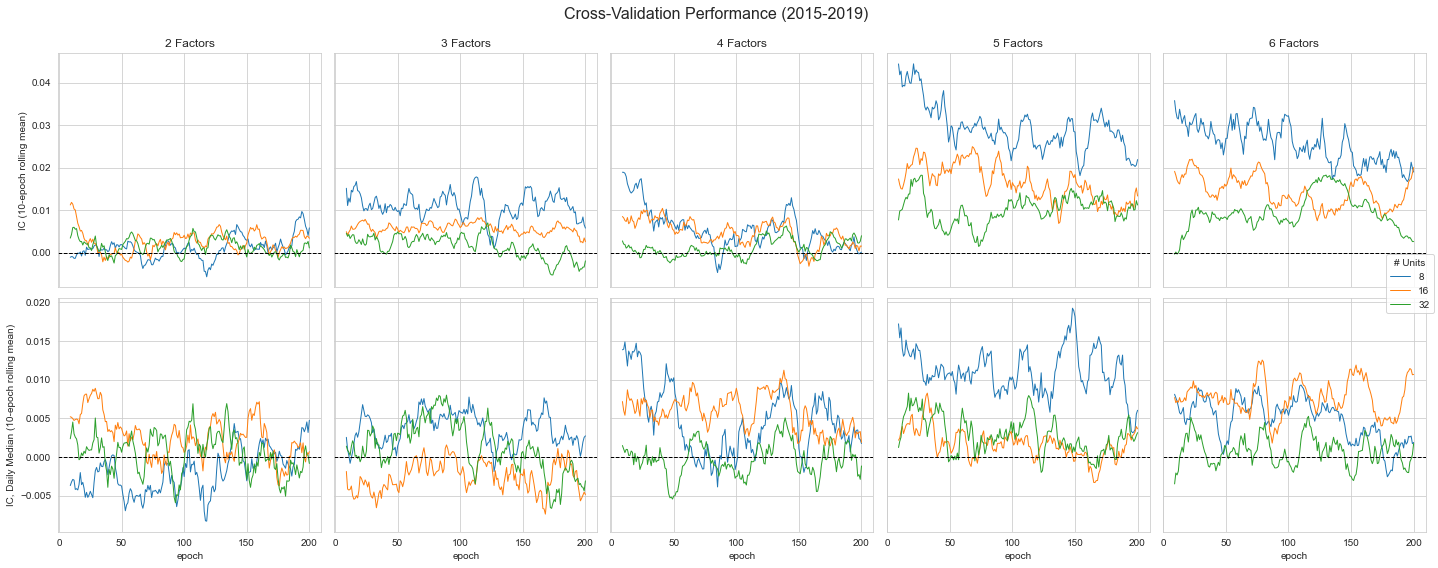

In [55]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/cv_performance', dpi=300);

## Generate Predictions

In [50]:
epoch = 25
n_factors = 5
units = 8

In [59]:
for epoch in range(5, 26):
    s = []
    print(f'\nEpoch: {epoch}')
    predictions = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data, train_idx, val_idx)          
        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  validation_data=([X1_val, X2_val], y_val),
                  epochs=epoch,
                  verbose=0, shuffle=True)
        result = (pd.DataFrame({'y_pred': model.predict([X1_val, X2_val]).reshape(-1), 
                               'y_true': y_val.stack().values},
                             index=y_val.stack().index)
                  .replace(-2, np.nan).dropna())
        r0 = spearmanr(result.y_true, result.y_pred)[0]
        r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])
        print(f'{r0:6.2%} | {r1.mean():6.2%} | {r1.median():6.2%}')
        s.append([r0, r1.mean(), r1.median()])
        predictions.append(result)
    s = pd.DataFrame(s, columns=['ic', 'avg', 'med']).mean()
    print(f'{s.ic:6.2%} | {s.avg:6.2%} | {s.med:6.2%}')
#     predictions = pd.concat(predictions).sort_index()   


Epoch: 5
-0.63% | -1.53% | -2.58%
-2.59% | -0.45% |  0.28%
-2.06% | -2.25% | -1.63%
-0.03% |  0.05% |  2.08%
 4.69% |  1.28% |  1.99%
-0.12% | -0.58% |  0.03%

Epoch: 6
 1.49% |  1.81% |  2.14%
 0.18% | -1.80% | -4.16%
 4.13% |  3.26% |  3.05%
-1.95% |  0.58% | -0.38%
 1.26% |  1.80% |  1.37%
 1.02% |  1.13% |  0.40%

Epoch: 7
-0.15% |  3.78% |  2.75%
-0.59% | -0.01% | -1.40%
-1.24% | -0.16% | -1.39%
-1.25% |  0.91% |  0.64%
 2.81% |  2.13% |  4.33%
-0.08% |  1.33% |  0.99%

Epoch: 8
-0.90% |  1.28% |  1.70%
-2.43% | -0.68% | -0.26%
 2.19% |  1.19% |  0.23%
-0.11% | -0.11% |  1.08%
 1.19% | -0.76% | -0.66%
-0.01% |  0.18% |  0.42%

Epoch: 9
 3.86% |  0.60% |  0.06%
 2.20% |  0.64% |  0.14%
-0.83% | -0.83% | -0.47%
 0.68% |  0.28% |  0.28%
-0.32% | -1.36% | -1.66%
 1.12% | -0.13% | -0.33%

Epoch: 10
 4.01% |  1.47% |  0.43%
 0.70% |  0.72% |  1.07%
 1.68% |  1.18% |  1.56%
-1.56% | -0.50% |  0.57%
 1.11% | -0.39% |  0.72%
 1.19% |  0.50% |  0.87%

Epoch: 11
-0.38% | -1.26% | -0.85%
-2.

In [45]:
predictions = predictions.sort_index()

In [41]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 823184 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-20 00:00:00'), 'ZYME')
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_pred  823184 non-null  float32
 1   y_true  823184 non-null  float64
dtypes: float32(1), float64(1)
memory usage: 12.6+ MB


In [42]:
predictions.to_hdf('predictions.h5', 'predictions')